# HOMO-LUMO Gap Predictions

### Problem Statement & Motivation

Accurately predicting quantum chemical properties like the HOMO–LUMO energy gap is essential for advancing materials science, drug discovery, and electronic design. The HOMO–LUMO gap is particularly informative for assessing molecular reactivity and stability. While Density Functional Theory (DFT) provides precise estimates, its high computational cost makes it impractical for large-scale screening of molecular libraries. This notebook explores machine learning alternatives that are fast, scalable, and interpretable, offering solutions that are accessible even on modest hardware.

### Related Work & Key Gap

Past work has shown that:

* DFT is accurate but computationally intensive
* ML models like kernel methods and GNNs show promise, but often require large models and expensive hardware

Key Gap: A need for lightweight, high-performing models that can run locally and integrate with user-friendly tools for deployment in research or education.

### Methodology & Evaluation

This notebook:

* Benchmarks a variety of 2D-based models using RDKit descriptors, Coulomb matrices, and graph neural networks (GNNs) on a 5k molecule subset
* Progresses to a hybrid GNN architecture combining OGB-standard graphs with SMILES-derived cheminformatics features
* Achieves **MAE = 0.159 eV**
* Visualizes results using parity plots, error inspection, and predicted-vs-true comparisons
* Evaluates both random and high-error cases to better understand model behavior

| Metric   | Best Model (Hybrid GNN) |
| -------- | ----------------------- |
| **MAE**  | 0.159 eV                |
| **RMSE** | 0.234 eV                |
| **R²**   | 0.965                   |


### Deployment & Accessibility

To make the model practically useful, an **interactive web app** was developed:

**Live App**: [HOMO–LUMO Gap Predictor on Hugging Face](https://huggingface.co/spaces/MooseML/homo-lumo-gap-predictor)

Features:

* **SMILES input** for any organic molecule
* **Real-time prediction** of the HOMO–LUMO gap
* **Molecular visualization**
* Simple **CSV logging** for result tracking

GitHub Repository: [MooseML/homo-lumo-gap-models](https://github.com/MooseML/homo-lumo-gap-models)


In [1]:
# general 
import pandas as pd
import numpy as np
from tqdm import tqdm
import ace_tools_open as tools
import optuna
import optuna.visualization as vis
import pickle
import joblib
import os 

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Module, Sequential, Dropout
from torch.utils.data import Subset
import torch.optim as optim
# PyTorch Geometric
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from transformers import get_cosine_schedule_with_warmup

# OGB dataset 
from ogb.lsc import PygPCQM4Mv2Dataset, PCQM4Mv2Dataset
from ogb.utils import smiles2graph
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# RDKit
# from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import Chem

# ChemML
from chemml.chem import Molecule, RDKitFingerprint, CoulombMatrix, tensorise_molecules
from chemml.models import MLP, NeuralGraphHidden, NeuralGraphOutput
from chemml.utils import regression_metrics

# SKlearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [2]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.10.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


In [3]:
# Paths - Fixed for Kaggle environment
if os.path.exists('/kaggle'):
    DATA_ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025'
    CHUNK_DIR = '/kaggle/working/processed_chunks'  # Writable directory
    BACKBONE_PATH = '/kaggle/input/polymer/best_gnn_transformer_hybrid.pt'
else:
    DATA_ROOT = 'data'
    CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
    BACKBONE_PATH = 'best_gnn_transformer_hybrid.pt'

TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

print(f"Data root: {DATA_ROOT}")
print(f"LMDB directory: {CHUNK_DIR}")
print(f"Train LMDB: {TRAIN_LMDB}")
print(f"Test LMDB: {TEST_LMDB}")

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb_fixed.py train
    !python build_polymer_lmdb_fixed.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


Data root: data
LMDB directory: data\processed_chunks
Train LMDB: data\processed_chunks\polymer_train3d_dist.lmdb
Test LMDB: data\processed_chunks\polymer_test3d_dist.lmdb
LMDBs already exist.


In [4]:
# /path/to/your_script.py
import os
import pandas as pd


train_path = os.path.join(DATA_ROOT, 'train.csv')
train_df   = pd.read_csv(train_path)

#  Keep only the columns we care about 
target_cols = ['SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
train_df   = train_df[target_cols]        # drops id and any other columns

#  Sample a subset (optional) 
n = len(train_df)
subset_size = n                         # change to whatever you need
subset_df   = train_df.sample(subset_size, random_state=42)

#  Save the subset as a CSV 
subset_path = os.path.join(DATA_ROOT, 'train_subset.csv')
subset_df.to_csv(subset_path, index=False)

print(f"Saved CSV with shape: {subset_df.shape}")
print(subset_df.head())

Saved CSV with shape: (7973, 6)
                                                 SMILES  Tg       FFV  \
7560  *C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC... NaN  0.386695   
1405                  *CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1 NaN  0.335504   
5196                              *CC(*)c1ccccc1C(=O)NC NaN  0.355580   
2087  *c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-... NaN  0.401573   
3337                    *CC(*)OC(=O)c1ccc(-c2ccccc2)cc1 NaN  0.353609   

            Tc  Density  Rg  
7560       NaN      NaN NaN  
1405       NaN      NaN NaN  
5196  0.183667      NaN NaN  
2087       NaN      NaN NaN  
3337       NaN      NaN NaN  


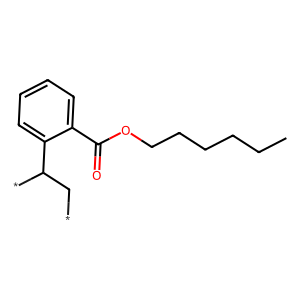

In [5]:
mol = Molecule(subset_df['SMILES'][0], input_type='smiles')
mol.visualize()

In [6]:
df = pd.read_csv(subset_path)
print(f"Loaded {len(df)} molecules.")

Loaded 7973 molecules.


In [7]:
df.head(5)

,SMILES,Tg,FFV,Tc,Density,Rg
0,*C=Cc1ccc2c3ccc(*)cc3n(-c3ccc(OCCCCCCCCCC)c(OC...,NaN,0.386695,NaN,NaN,NaN
1,*CC(=O)NCCCCCCNC(=O)Cc1ccc(O*)cc1,NaN,0.335504,NaN,NaN,NaN
2,*CC(*)c1ccccc1C(=O)NC,NaN,0.355580,0.183667,NaN,NaN
3,*c1ccc2c(c1)C(=O)N(c1ccc(Oc3ccc(N4C(=O)c5ccc(-...,NaN,0.401573,NaN,NaN,NaN
4,*CC(*)OC(=O)c1ccc(-c2ccccc2)cc1,NaN,0.353609,NaN,NaN,NaN


In [8]:
missing_values = df.isnull().sum()
total_rows = len(df)
percent_missing = (missing_values / total_rows) * 100

missing_df = pd.DataFrame({
    'Total Missing': missing_values,
    'Percent Missing': percent_missing
})

print("Missing Values by Column:")
print(missing_df)
print("\nFeature Statistics (Min, Max, Mean, etc.):")
print(df[['Tg', 'FFV', 'Tc', 'Density', 'Rg']].describe())

Missing Values by Column:
         Total Missing  Percent Missing
SMILES               0         0.000000
Tg                7462        93.590869
FFV                943        11.827418
Tc                7236        90.756303
Density           7360        92.311551
Rg                7359        92.299009

Feature Statistics (Min, Max, Mean, etc.):
               Tg          FFV          Tc     Density          Rg
count  511.000000  7030.000000  737.000000  613.000000  614.000000
mean    96.452314     0.367212    0.256334    0.985484   16.419787
std    111.228279     0.029609    0.089538    0.146189    4.608640
min   -148.029738     0.226992    0.046500    0.748691    9.728355
25%     13.674509     0.349549    0.186000    0.890243   12.540328
50%     74.040183     0.364264    0.236000    0.948193   15.052194
75%    161.147595     0.380790    0.330500    1.062096   20.411067
max    472.250000     0.777097    0.524000    1.840999   34.672906


The only property that appears will succeed with a simple imputation strategy is FFV. All other properties contain very high percent missing. Therefore, I will impute median for FFV, train a model for FFV, and train separate models for other properties. I will attempt to filter out missing values for each property. If this yields uncessful, I may explore sampling techniques or use the trained model to impute values to train a secondaery model. |

# FFV Model

In [9]:
# Create a new DataFrame with only the columns you're keeping
df_ffv = df[['SMILES', 'FFV']].copy()

print("New DataFrame shape:", df_ffv.shape)
print("FFV Missing Values:")
print(df_ffv.isnull().sum())

# Calculate the median of the FFV column
ffv_median = df_ffv['FFV'].median()

# Impute the missing values with the median
df_ffv['FFV'].fillna(ffv_median, inplace=True)

print("FFV Missing Values after imputation:")
print(df_ffv.isnull().sum())

New DataFrame shape: (7973, 2)
FFV Missing Values:
SMILES      0
FFV       943
dtype: int64
FFV Missing Values after imputation:
SMILES    0
FFV       0
dtype: int64


In [10]:
from rdkit.Chem import AllChem, Descriptors, HybridizationType, SanitizeFlags
def rdkit_ogb_agree(smi: str) -> bool:
    m = Chem.MolFromSmiles(smi)
    if m is None:
        return False
    return m.GetNumAtoms() == smiles2graph(smi)["num_nodes"]

def canonicalize_polymer_smiles(smiles: str, cap_atomic_num: int = 6) -> str:
    """
    Turn every '*' (dummy atom) into a real atom (default C) in the RDKit graph,
    preserving existing bond orders/stereo; sanitize, remove explicit Hs, and
    return canonical isomeric SMILES.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    if mol is None:
        raise ValueError(f"RDKit could not parse SMILES: {smiles}")

    rw = Chem.RWMol(mol)
    for a in rw.GetAtoms():
        if a.GetAtomicNum() == 0:   # '*'
            a.SetAtomicNum(cap_atomic_num)  # 6 = carbon
            a.SetFormalCharge(0)
            a.SetIsAromatic(False)
            a.SetNoImplicit(False)
            a.SetNumExplicitHs(0)

    mol2 = rw.GetMol()
    try:
        Chem.SanitizeMol(mol2)
    except Exception:
        Chem.SanitizeMol(mol2, sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ SanitizeFlags.SANITIZE_KEKULIZE)
        Chem.Kekulize(mol2, clearAromaticFlags=True)

    mol2 = Chem.RemoveHs(mol2)
    return Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)

In [11]:
# Build the molecule list 
valid_mol_objs = []
valid_targets = []  # Now stores an array with one value per molecule

# Correct way to iterate over the dataframe
for i, row in df_ffv.iterrows():
    smi = row['SMILES']
    
    # 2.a Clean the SMILES first
    cleaned_smiles = canonicalize_polymer_smiles(smi)

    try:
        # 2.b Create your custom Molecule from the cleaned string
        mol = Molecule(cleaned_smiles, input_type='smiles')
        mol.hydrogens('add')
        mol.to_xyz(optimizer='MMFF', maxIters=200)

        # 2.c Only keep molecules that got a 3-D geometry
        if mol.xyz is not None:
            valid_mol_objs.append(mol)
            
            # Keep only the 'FFV' target column as a NumPy array
            valid_targets.append(
                row[['FFV']].values
            )
        else:
            print(f"Skipped bc missing xyz: {smi}")

    except Exception as e:
        print(f"Failed on {smi} | Reason: {e}")

print(f"Kept {len(valid_mol_objs)} molecules after filtering.")

Failed on *Nc1cccc2c(N[Se]*)cccc12 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *c1ccc2c(c1)C(=O)N(c1ccc(-c3ccc(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c(OCCCCCCOc4ccc(/C=C/c5ccc(F)cc5)cc4)c3)cc1OCCCCCCOc1ccc(/C=C/c3ccc(F)cc3)cc1)C2=O | Reason: Bad Conformer Id
Failed on *c1cc(C(c2ccc(OCCN(C)c3ccc(C=CC4=CC(=C(C#N)C(=O)OCCc5ccccc5)CC(C)(C)C4)cc3)c(N3C(=O)c4ccc(Oc5ccc6c(c5)C(=O)N(*)C6=O)cc4C3=O)c2)(C(F)(F)F)C(F)(F)F)ccc1OCCN(c1ccccc1)c1ccc(C=CC2=CC(=C(C#N)C(=O)OCCc3ccccc3)CC(C)(C)C2)cc1 | Reason: Bad Conformer Id
Failed on *Nc1ccc(C2(c3ccc(N*)cc3[C@]34C[C@@H]5C[C@H](C[C@@H](C5)C3)C4)c3ccccc3-c3ccccc32)c([C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)c1 | Reason: Bad Conformer Id
Failed on *CCCCCOC(=O)CCCCCCCCCCN1C(=O)c2ccc(-c3ccc(-c4ccc5c(c4)C(=O)N(CCCCCCCCCCC(=O)OCCCCCN4C(=O)c6ccc(-c7ccc8c(c7)C(=O)N(*)C8=O)cc6C4=O)C5=O)cc3)cc2C1=O | Reason: Bad Conformer Id
Failed on *Nc1ccc(N*)c2c3ccc(cc3)c12 | Reason: Bad Conformer Id
Failed on *C(C)=C(*)[Ge](C)(

[11:17:09] UFFTYPER: Unrecognized atom type: Cd1+2 (18)


Failed on *CCCCCOC(=O)c1ccccc1C(=O)O[Cd]OC(=O)c1ccccc1C(=O)OCCCCCOC(=O)NCCCCCCNC(=O)O* | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *CCCCCCOC(=O)c1cc(OCCCCCCOc2ccc(N=Nc3ccc(C#N)cc3)cc2)cc(C(=O)OCCCCCCN2C(=O)c3ccc(-c4ccc(-c5ccc6c(c5)C(=O)N(*)C6=O)cc4)cc3C2=O)c1 | Reason: Bad Conformer Id
Failed on *CC(*)C(=O)OC(C1COC(CP(=O)(OCC)OCC)O1)C(OC(=O)C(*)(C)C*)C1COC(CP(=O)(OCC)OCC)O1 | Reason: Bad Conformer Id
Failed on *CCCCOCCCCOCCCCOC(=O)c1ccc(N=Cc2cc(OCCC(C)CCCC(C)C)c(C=Nc3ccc(C(=O)O*)cc3)cc2OCCC(C)CCCC(C)C)cc1 | Reason: Bad Conformer Id
Failed on *c1nnc(-c2cc(CCCCCCCCCC)c(-c3sc(-c4nnc(-c5cc(OCCCCCCCC)c(*)cc5OCCCCCCCC)o4)cc3CCCCCCCCCC)s2)o1 | Reason: Bad Conformer Id
Failed on *CC(*)c1ccc(OP2(OCCOCCOCCOC)=NP(OCCOCCOCCOC)(OCCOCCOCCOC)=NP(OCCOCCOCCOC)(OCCOCCOCCOC)=N2)cc1 | Reason: Bad Conformer Id


[11:17:56] UFFTYPER: Unrecognized atom type: S_6+6 (2)


Failed on *NS(N)(N)(N*)(c1ccccc1)c1ccccc1 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *CCCCCCCCCCOc1ccc(C=Cc2ccc(OCCCCCCCCCCOP(=O)(O*)OCCCCCCCCCCOc3ccc(N=Nc4ccc(-c5ccccc5)cc4)cc3)cc2)cc1 | Reason: Bad Conformer Id
Failed on *CC(*)c1ccc(C([Sn](C)(C)C)[Sn](C)(C)C)cc1 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *C=Cc1ccc(*)c(OCc2cc(OCc3cc(OCCC(C)CCCC(C)C)cc(OCCC(C)CCCC(C)C)c3)cc(OCc3cc(OCC(CC)CCCC)cc(OCC(CC)CCCC)c3)c2)c1 | Reason: Bad Conformer Id
Failed on *C=C(C#N)c1ccc(-c2ccc(C=CC3=CC(=C(C#N)C#N)C=C(C=Cc4ccc(-c5ccc(C(C#N)=Cc6cc(C=C(C#N)c7ccc(-c8ccc(C=CC9=CC(=C(C#N)C#N)C=C(C=Cc%10ccc(-c%11ccc(C(C#N)=C*)cc%11)s%10)O9)s8)cc7)c7c(c6)C(CC)(CC)c6cc(*)ccc6-7)cc5)s4)O3)s2)cc1 | Reason: Bad Conformer Id
Failed on *C=Cc1ccc2c(c1)C(CCCCCCOc1ccc3ccc(=O)oc3c1)(CCCCCCOc1ccc3ccc(=O)oc3c1)c1cc(C=Cc3ccc4c(c3)C(CCCCCC)(CCCCCC)c3cc(*)ccc3-4)ccc1-2 | Reason: Bad Conformer Id
Failed on *CC(*)(C)C(=O)OCC1CC(NC(=O)C

[11:20:16] UFFTYPER: Unrecognized atom type: Ca1+2 (2)


Failed on *O[Ca]OC(=O)c1ccccc1C(=O)OCCCCCOC(=O)NCCCCCCNC(=O)OCCCCCOC(=O)c1ccccc1C(*)=O | Reason: The MMFF parameters are not available for all of the molecule's atoms.


[11:20:34] UFFTYPER: Unrecognized atom type: Se2+2 (13)


Failed on *CC(*)(C)C(=O)OCc1ccc[se]1 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *Oc1ccc(C(c2ccc(OP3(Oc4ccc(C(=O)OC)cc4)=NP(Oc4ccc(C(=O)OC)cc4)(Oc4ccc(C(=O)OC)cc4)=NP(*)(Oc4ccc(C(=O)OC)cc4)=N3)cc2)(C(F)(F)F)C(F)(F)F)cc1 | Reason: Bad Conformer Id
Failed on *CCN(CCOC(=O)NCC1(C)CC(NC(=O)O*)CC(C)(C)C1)c1ccc(N=Nc2ccc(B(c3c(C)cc(C)cc3C)c3c(C)cc(C)cc3C)cc2)cc1 | Reason: The MMFF parameters are not available for all of the molecule's atoms.
Failed on *c1ccc2c(c1)C(=O)N(c1cc(C(c3ccc(OCCN(CC)c4ccc(N=Nc5ccc([N+](=O)[O-])cc5)cc4)c(N4C(=O)c5ccc(C(*)(C(F)(F)F)C(F)(F)F)cc5C4=O)c3)(C(F)(F)F)C(F)(F)F)ccc1OCCN(CC)c1ccc(N=Nc3ccc([N+](=O)[O-])cc3)cc1)C2=O | Reason: Bad Conformer Id
Failed on *O[Si](C)(C)COC(=O)CCCCCCCCC(=O)Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C=C4CCCCC(=Cc5ccc(Oc6ccc(S(=O)(=O)c7ccc(OC(=O)CCCCCCCCC(=O)OC[Si](*)(C)C)cc7)cc6)cc5)C4=O)cc3)cc2)cc1 | Reason: Bad Conformer Id
Failed on *Nc1cccc(-c2cc(-c3ccc(C4(c5ccccc5)c5ccccc5-c5ccccc54)cc3)c(-c3ccc(C4(c5

In [12]:
df_clean = pd.DataFrame({
    'SMILES': [m.smiles for m in valid_mol_objs],
    # 'Tg':     [t[0] for t in valid_targets],
    'FFV':    [t[0] for t in valid_targets],
    # 'Tc':     [t[2] for t in valid_targets],
    # 'Density':[t[3] for t in valid_targets],
    # 'Rg':     [t[4] for t in valid_targets],
})
print(f"Kept {len(df_clean)} molecules after filtering.")
df_clean.to_csv('cleaned_ffv_dataset.csv', index=False)
print("Saved cleaned FFV dataset to 'cleaned_ffv_dataset.csv'.")

# Target matrix 
# y = np.stack(valid_targets) # shape: (N, 5)
y = np.array([t[0] for t in valid_targets]) 
print("Target shape:", y.shape)
      
# compute descriptors
fp_featurizer = RDKitFingerprint(
    fingerprint_type='morgan', vector='bit', n_bits=1024, radius=3
)
# cm_featurizer = CoulombMatrix(cm_type='SC')

X_fp = fp_featurizer.represent(valid_mol_objs)
# X_cm = cm_featurizer.represent(valid_mol_objs)

print("RDKit FP shape:", X_fp.shape)
# print("Coulomb Matrix shape:", X_cm.shape)

Kept 7868 molecules after filtering.
Saved cleaned FFV dataset to 'cleaned_ffv_dataset.csv'.
Target shape: (7868,)
RDKit FP shape: (7868, 1024)


In [13]:
# # 1. make separate train/test splits for both scaled and unscaled targets
# # scaled targets (MLP, KRR, GNN)
# X_train_fp_scaled, X_test_fp_scaled, y_train_scaled, y_test_scaled = train_test_split(
#     X_fp, y, test_size=0.2, random_state=42
# )
# # X_train_cm_scaled, X_test_cm_scaled, _, _ = train_test_split(
# #     X_cm, y, test_size=0.2, random_state=42
# # )

# xscaler_fp = StandardScaler()
# # xscaler_cm = StandardScaler()
# yscaler = StandardScaler()

# X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp_scaled)
# X_test_fp_scaled  = xscaler_fp.transform(X_test_fp_scaled)

# # X_train_cm_scaled = xscaler_cm.fit_transform(X_train_cm_scaled)
# # X_test_cm_scaled  = xscaler_cm.transform(X_test_cm_scaled)

# y_train_scaled = yscaler.fit_transform(y_train_scaled)
# y_test_scaled  = yscaler.transform(y_test_scaled)

# # b) unscaled targets (Random Forest)
# y_unscaled = y              
# X_train_fp_unscaled, X_test_fp_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(
#     X_fp, y_unscaled, test_size=0.2, random_state=42
# )

# # 2. show shapes
# tools.display_dataframe_to_user(
#     name="Cleaned Feature Splits",
#     dataframe=pd.DataFrame({
#         "Split": [
#             "X_train_fp_scaled", "X_test_fp_scaled",
#             # "X_train_cm_scaled", "X_test_cm_scaled",
#             "y_train_scaled",   "y_test_scaled",
#             "X_train_fp_unscaled", "X_test_fp_unscaled",
#             "y_train_unscaled",   "y_test_unscaled"
#         ],
#         "Shape": [
#             X_train_fp_scaled.shape, X_test_fp_scaled.shape,
#             # X_train_cm_scaled.shape, X_test_cm_scaled.shape,
#             y_train_scaled.shape,   y_test_scaled.shape,
#             X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
#             y_train_unscaled.shape,   y_test_unscaled.shape
#         ]
#     })
# )

# 1. make separate train/test splits for both scaled and unscaled targets
# a) Scaled targets (for KRR)
# Your y is now a 1D array of FFV values.
X_train_fp, X_test_fp, y_train, y_test = train_test_split(
    X_fp, y, test_size=0.2, random_state=42
)

xscaler_fp = StandardScaler()
yscaler = StandardScaler()

X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp)
X_test_fp_scaled = xscaler_fp.transform(X_test_fp)

# Reshape y arrays for the StandardScaler
y_train_scaled = yscaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = yscaler.transform(y_test.reshape(-1, 1))

# b) Unscaled targets (for models that don't need scaling, like Random Forest)
# These are the original, unscaled splits. You can use the variables you already created.
X_train_fp_unscaled = X_train_fp
X_test_fp_unscaled = X_test_fp
y_train_unscaled = y_train
y_test_unscaled = y_test

# 2. show shapes
# The shape display now reflects the single target variable
tools.display_dataframe_to_user(
    name="Cleaned Feature Splits",
    dataframe=pd.DataFrame({
        "Split": [
            "X_train_fp_scaled", "X_test_fp_scaled",
            "y_train_scaled", "y_test_scaled",
            "X_train_fp_unscaled", "X_test_fp_unscaled",
            "y_train_unscaled", "y_test_unscaled"
        ],
        "Shape": [
            X_train_fp_scaled.shape, X_test_fp_scaled.shape,
            y_train_scaled.shape, y_test_scaled.shape,
            X_train_fp_unscaled.shape, X_test_fp_unscaled.shape,
            y_train_unscaled.shape, y_test_unscaled.shape
        ]
    })
)

Cleaned Feature Splits


## Kernel Ridge Regression baseline first

In [14]:
# Kernel Ridge on RDKit fingerprints
krr = KernelRidge(kernel='rbf', alpha=1.0)
krr.fit(X_train_fp_scaled, y_train_scaled)

# predict on scaled test set
y_pred_krr_scaled = krr.predict(X_test_fp_scaled)

# Inverse transform predictions and test targets to compare with unscaled values
# You must reshape y_pred_krr_scaled and y_test_scaled to 2D before inverse transforming
y_pred_krr = yscaler.inverse_transform(y_pred_krr_scaled.reshape(-1, 1)).flatten()
y_test_krr = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("Kernel Ridge (RDKit FP)")
metrics_krr = regression_metrics(y_test_krr, y_pred_krr)
print(metrics_krr[['MAE', 'RMSE', 'r_squared']])

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  0.010427  0.019614   0.526114


## Random Forest Regression baseline 

In [15]:
# Random Forest (RDKit FP) 
rfr = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
rfr.fit(X_train_fp_unscaled, y_train_unscaled)
# predict
y_pred_rfr = rfr.predict(X_test_fp_unscaled)
# eval
print("Random Forest (RDKit FP)")
metrics_rfr = regression_metrics(y_test_unscaled, y_pred_rfr)
print(metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  0.009401  0.019148    0.54836


## Multi-Layer Perceptron with Morgan Fingerprints baseline 

In [16]:
# MLP (Fingerprint)
mlp_fp = MLP(
    engine='tensorflow',
    nfeatures=X_train_fp_scaled.shape[1],
    nneurons=[64, 128], # These are the hidden layers
    activations=['ReLU', 'ReLU'],
    learning_rate=0.01,
    alpha=0.001,
    nepochs=200,
    batch_size=64,
    loss='mean_squared_error',
    is_regression=True
)

mlp_fp.fit(X=X_train_fp_scaled, y=y_train_scaled.ravel()) # Use .ravel() to convert to 1D
y_pred_fp_scaled = mlp_fp.predict(X_test_fp_scaled)
# Reshape the output from predict() to 2D before inverse transforming
y_pred_fp = yscaler.inverse_transform(y_pred_fp_scaled.reshape(-1, 1)).flatten()
y_test_fp = yscaler.inverse_transform(y_test_scaled).flatten()

# Eval against true unscaled test target
print("MLP (RDKit FP)")
metrics_mlp = regression_metrics(y_test, y_pred_fp)
print(metrics_mlp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
99/99 [==============================] - 0s 1ms/step - loss: 0.8855
Epoch 2/200
99/99 [==============================] - 0s 1ms/step - loss: 0.5339
Epoch 3/200
99/99 [==============================] - 0s 1ms/step - loss: 0.3997
Epoch 4/200
99/99 [==============================] - 0s 1ms/step - loss: 0.3229
Epoch 5/200
99/99 [==============================] - 0s 1ms/step - loss: 0.2680
Epoch 6/200
99/99 [==============================] - 0s 1ms/step - loss: 0.2350
Epoch 7/200
99/99 [==============================] - 0s 1ms/step - loss: 0.2218
Epoch 8/200
99/99 [==============================] - 0s 1ms/step - loss: 0.2035
Epoch 9/200
99/99 [==============================] - 0s 1ms/step - loss: 0.1949
Epoch 10/200
99/99 [==============================] - 0s 1ms/step - loss: 0.1869
Epoch 11/200
99/99 [==============================] - 0s 1ms/step - loss: 0.1793
Epoch 12/200
99/99 [==============================] - 0s 1ms/step - loss: 0.1742
Epoch 13/200
99/99 [=================

## Multi-Layer Perceptron with Coulomb Matrix representation baseline 

In [17]:
# # MLP (Coulomb matrix)
# mlp_cm = MLP(
#     engine='tensorflow', 
#     nfeatures=X_train_cm_scaled.shape[1], 
#     nneurons=[64, 128], 
#     activations=['ReLU', 'ReLU'],
#     learning_rate=0.0001, 
#     alpha=0.001, 
#     nepochs=100, 
#     batch_size=64, 
#     loss='mean_squared_error', 
#     is_regression=True
#     )

# mlp_cm.fit(X=X_train_cm_scaled, y=y_train_scaled)
# y_pred_cm_scaled = mlp_cm.predict(X_test_cm_scaled)
# y_pred_cm = yscaler.inverse_transform(y_pred_cm_scaled)
# y_test_cm = yscaler.inverse_transform(y_test_scaled)

In [18]:
# eval
results = {"Kernel Ridge (RDKit FP)": regression_metrics(y_test_krr, y_pred_krr),
           "Random Forest (RDKit FP)": regression_metrics(y_test_unscaled, y_pred_rfr),
           "MLP (RDKit FP)": regression_metrics(y_test_fp, y_pred_fp),
        #    "MLP (Coulomb Matrix)": regression_metrics(y_test_cm, y_pred_cm)
        }

# display
print("Final Model Comparison")
for name, metrics_df in results.items():
    print(f"\n{name}")
    print(metrics_df[['MAE', 'RMSE', 'r_squared']])

Final Model Comparison

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  0.010427  0.019614   0.526114

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  0.009401  0.019148    0.54836

MLP (RDKit FP)
       MAE      RMSE  r_squared
0  0.00976  0.019727   0.520636


## Parity Plots and Residuals Histograms

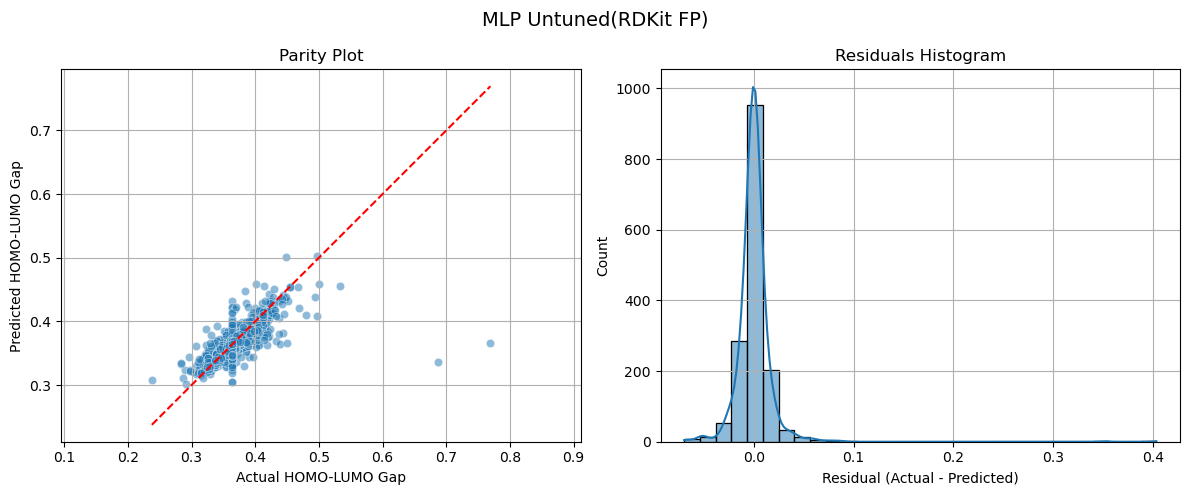

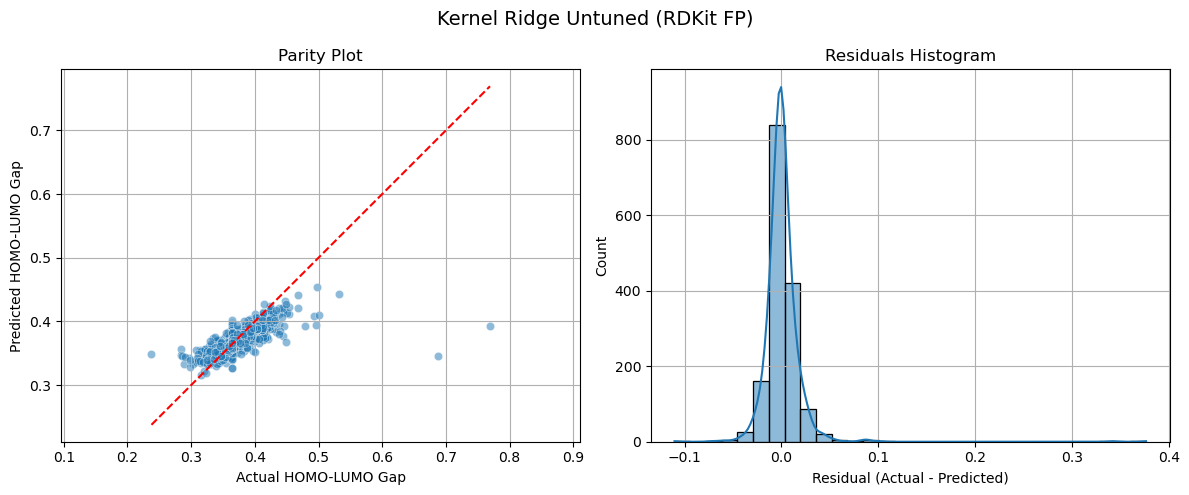

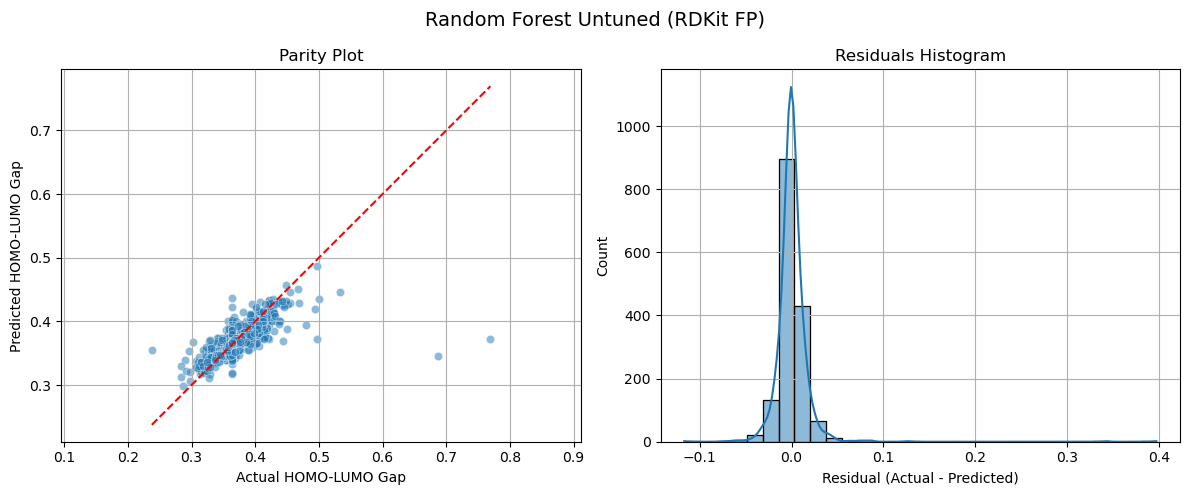

In [19]:
def plot_regression_results(y_true, y_pred, title="Model Evaluation", save_dir="plots"):
    residuals = y_true.flatten() - y_pred.flatten()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # parity plot
    sns.scatterplot(ax=axes[0], x=y_true.flatten(), y=y_pred.flatten(), alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], '--r')
    axes[0].set_xlabel("Actual HOMO-LUMO Gap")
    axes[0].set_ylabel("Predicted HOMO-LUMO Gap")
    axes[0].set_title("Parity Plot")
    axes[0].grid(True)
    axes[0].axis('equal')

    # residuals histogram
    sns.histplot(ax=axes[1], data=residuals, bins=30, kde=True)
    axes[1].set_title("Residuals Histogram")
    axes[1].set_xlabel("Residual (Actual - Predicted)")
    axes[1].grid(True)

    # overall title
    fig.suptitle(title, fontsize=14)

    # save fig as pdf for best overleaf upload format 
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{title.lower().replace(' ', '_')}_plots.pdf")
    fig.savefig(filename, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

plot_regression_results(y_test_fp, y_pred_fp, title="MLP Untuned(RDKit FP)")
# plot_regression_results(y_test_cm, y_pred_cm, title="MLP Untuned (Coulomb Matrix)")
plot_regression_results(y_test_krr, y_pred_krr, title="Kernel Ridge Untuned (RDKit FP)")
plot_regression_results(y_test_unscaled, y_pred_rfr, title="Random Forest Untuned (RDKit FP)")

## Tune hyperparameters for baseline models with Optuna 

In [20]:
def objective_krr(trial):
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True) if kernel == 'rbf' else None
    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma) if gamma else KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_krr = optuna.create_study(direction='minimize')
study_krr.optimize(objective_krr, n_trials=100)

[I 2025-09-05 11:23:10,324] A new study created in memory with name: no-name-eb10d540-cb40-40f0-8a64-17ba710468a1
[I 2025-09-05 11:23:21,964] Trial 0 finished with value: 0.01736093988149412 and parameters: {'alpha': 0.12719504270639745, 'kernel': 'rbf', 'gamma': 0.2606920743864998}. Best is trial 0 with value: 0.01736093988149412.
[I 2025-09-05 11:23:23,776] Trial 1 finished with value: 0.009915831181744338 and parameters: {'alpha': 0.8723061007748333, 'kernel': 'poly'}. Best is trial 1 with value: 0.009915831181744338.
[I 2025-09-05 11:23:33,527] Trial 2 finished with value: 0.017399925237213464 and parameters: {'alpha': 0.22144241776567222, 'kernel': 'rbf', 'gamma': 0.3035223241219924}. Best is trial 1 with value: 0.009915831181744338.
[I 2025-09-05 11:23:35,291] Trial 3 finished with value: 0.014006456239359446 and parameters: {'alpha': 0.08743110894882931, 'kernel': 'rbf', 'gamma': 0.005266099784933218}. Best is trial 1 with value: 0.009915831181744338.
[I 2025-09-05 11:23:36,626]

In [ ]:
def objective_rfr(trial):
    n_estimators = trial.suggest_int("n_estimators", 300, 3000, step=100)
    max_depth = trial.suggest_int("max_depth", 10, 500, step=10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20, step=2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2', 1.0])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_fp_unscaled, y_train_unscaled)
    preds = model.predict(X_test_fp_unscaled)
    metrics = regression_metrics(y_test_unscaled, preds)
    return metrics['MAE'][0]

study_rfr = optuna.create_study(direction='minimize')
study_rfr.optimize(objective_rfr, n_trials=1000)

[I 2025-09-05 11:26:22,994] A new study created in memory with name: no-name-fb189628-7cf4-4c3d-b72f-233e6a98e3d4
[I 2025-09-05 11:26:29,515] Trial 0 finished with value: 0.009747798177688225 and parameters: {'n_estimators': 250, 'max_depth': 20}. Best is trial 0 with value: 0.009747798177688225.
[I 2025-09-05 11:26:40,256] Trial 1 finished with value: 0.0093197693291302 and parameters: {'n_estimators': 300, 'max_depth': 80}. Best is trial 1 with value: 0.0093197693291302.
[I 2025-09-05 11:26:43,785] Trial 2 finished with value: 0.00940148012162601 and parameters: {'n_estimators': 100, 'max_depth': 30}. Best is trial 1 with value: 0.0093197693291302.
[I 2025-09-05 11:26:47,659] Trial 3 finished with value: 0.009286645594621348 and parameters: {'n_estimators': 100, 'max_depth': 80}. Best is trial 3 with value: 0.009286645594621348.
[I 2025-09-05 11:26:53,216] Trial 4 finished with value: 0.009287320441671593 and parameters: {'n_estimators': 150, 'max_depth': 100}. Best is trial 3 with v

In [22]:
def objective_mlp_fp(trial):
    lr = trial.suggest_float('lr', 1e-4, 2e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-4, 5e-2, log=True)
    act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
    n1 = trial.suggest_int('n1', 128, 384, step=64)
    n2 = trial.suggest_int('n2', 128, 384, step=64)

    model = MLP(engine='tensorflow', nfeatures=X_train_fp_scaled.shape[1], nneurons=[n1, n2],
                activations=[act, act], learning_rate=lr, alpha=alpha,
                nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)
    
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_mlp_fp = optuna.create_study(direction='minimize')
study_mlp_fp.optimize(objective_mlp_fp, n_trials=100)

[I 2025-09-05 11:34:53,113] A new study created in memory with name: no-name-26d951c9-62af-4f78-b3b9-14ec00ebad61


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3099
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0269
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9149
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8439
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7914
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7495
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7135
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6821
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6552
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6311
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6102
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5908
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:35:07,900] Trial 0 finished with value: 0.013115788440363738 and parameters: {'lr': 0.0002522076781549249, 'alpha': 0.00046621724564073003, 'activation': 'relu', 'n1': 192, 'n2': 320}. Best is trial 0 with value: 0.013115788440363738.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0549
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7282
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 1.6163
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.5519
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.5067
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4726
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4450
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4214
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4014
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3834
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3677
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3531
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:35:22,184] Trial 1 finished with value: 0.013535616909820431 and parameters: {'lr': 0.00014374090573228177, 'alpha': 0.0011222417560229714, 'activation': 'tanh', 'n1': 320, 'n2': 384}. Best is trial 0 with value: 0.013115788440363738.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 2.0543
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 1.6303
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4998
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4287
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3800
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3441
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3145
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2895
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2684
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2500
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2335
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2184
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:35:35,724] Trial 2 finished with value: 0.013658502972606335 and parameters: {'lr': 0.00017289765139634939, 'alpha': 0.0011477579352283094, 'activation': 'tanh', 'n1': 320, 'n2': 192}. Best is trial 0 with value: 0.013115788440363738.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 14.9771
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 14.3723
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 13.9746
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 13.6243
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 13.3013
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 12.9923
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 12.6961
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 12.4115
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 12.1362
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 11.8710
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 11.6113
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 11.3604
Epoch 13/100
99/99 [=====

[I 2025-09-05 11:35:49,465] Trial 3 finished with value: 0.01115842159455393 and parameters: {'lr': 0.0002913250219957788, 'alpha': 0.018210907788425313, 'activation': 'relu', 'n1': 320, 'n2': 256}. Best is trial 3 with value: 0.01115842159455393.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9606
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5280
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4035
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2998
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2681
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2271
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1448
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1243
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0954
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0526
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0499
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0195
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:36:03,850] Trial 4 finished with value: 0.013242600651326937 and parameters: {'lr': 0.007194195798389976, 'alpha': 0.001115056272060238, 'activation': 'sigmoid', 'n1': 320, 'n2': 384}. Best is trial 3 with value: 0.01115842159455393.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 5.2277
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 4.7307
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 4.4954
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 4.2965
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 4.1150
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 3.9494
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 3.7908
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 3.6457
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 3.5066
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 3.3782
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 3.2525
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 3.1340
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:36:18,003] Trial 5 finished with value: 0.012061542261831388 and parameters: {'lr': 0.00150717360081319, 'alpha': 0.006032067861792561, 'activation': 'tanh', 'n1': 384, 'n2': 128}. Best is trial 3 with value: 0.01115842159455393.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 3.0172
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 2.7531
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.6332
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 2.5533
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 2.4928
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.4434
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 2.4008
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3641
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3307
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3010
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 2.2743
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 2.2495
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:36:34,150] Trial 6 finished with value: 0.012296146409874593 and parameters: {'lr': 0.00019008009472033858, 'alpha': 0.0036911027515254585, 'activation': 'gelu', 'n1': 192, 'n2': 192}. Best is trial 3 with value: 0.01115842159455393.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2152
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9183
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8230
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7830
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7661
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7424
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6874
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6808
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6741
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6539
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6557
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6477
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:36:47,848] Trial 7 finished with value: 0.012019420469485991 and parameters: {'lr': 0.005279737969249226, 'alpha': 0.0003805187597363156, 'activation': 'sigmoid', 'n1': 384, 'n2': 256}. Best is trial 3 with value: 0.01115842159455393.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 16.8725
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 9.1468
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 5.0717
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 2.9038
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7544
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1419
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8139
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6190
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5267
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4626
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4177
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3942
Epoch 13/100
99/99 [================

[I 2025-09-05 11:37:04,024] Trial 8 finished with value: 0.010653243784617239 and parameters: {'lr': 0.004333731829722532, 'alpha': 0.035407812062681246, 'activation': 'gelu', 'n1': 192, 'n2': 384}. Best is trial 8 with value: 0.010653243784617239.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7368
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4631
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.3757
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.3157
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.2633
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.2266
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1875
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1651
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1469
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1349
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1225
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.1160
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:37:18,507] Trial 9 finished with value: 0.012963837283192434 and parameters: {'lr': 0.005173986907135158, 'alpha': 0.00011713908980115587, 'activation': 'tanh', 'n1': 128, 'n2': 320}. Best is trial 8 with value: 0.010653243784617239.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 7.6199
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0703
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6529
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6292
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5935
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6462
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6324
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6032
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6144
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6436
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6026
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6698
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:37:34,509] Trial 10 finished with value: 0.012171503262986277 and parameters: {'lr': 0.01575961676201263, 'alpha': 0.03888261967792777, 'activation': 'gelu', 'n1': 128, 'n2': 320}. Best is trial 8 with value: 0.010653243784617239.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 26.1053
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 23.1025
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 20.6349
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 18.4590
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 16.5248
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 14.8014
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 13.2625
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 11.8880
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 10.6592
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 9.5608
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 8.5785
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 7.6995
Epoch 13/100
99/99 [========

[I 2025-09-05 11:37:48,432] Trial 11 finished with value: 0.00996313250358974 and parameters: {'lr': 0.0007042227500397805, 'alpha': 0.03956842589290186, 'activation': 'relu', 'n1': 256, 'n2': 256}. Best is trial 11 with value: 0.00996313250358974.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 22.2783
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 18.7768
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 15.9699
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 13.6091
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 11.6099
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 9.9123
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 8.4707
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 7.2451
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 6.2019
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 5.3155
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 4.5596
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 3.9148
Epoch 13/100
99/99 [============

[I 2025-09-05 11:38:02,540] Trial 12 finished with value: 0.009928964426289454 and parameters: {'lr': 0.000906490883574735, 'alpha': 0.04453103562006486, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 12 with value: 0.009928964426289454.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 8.3607
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 7.7463
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 7.4023
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 7.1085
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 6.8416
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 6.5953
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 6.3620
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 6.1407
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 5.9309
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 5.7305
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 5.5389
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 5.3560
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:38:16,429] Trial 13 finished with value: 0.010821877547980167 and parameters: {'lr': 0.0006816502855825132, 'alpha': 0.01200053960422833, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 12 with value: 0.009928964426289454.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 26.7970
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 21.5781
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 17.5465
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 14.2977
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 11.6667
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 9.5330
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 7.7983
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 6.3892
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 5.2422
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 4.3097
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 3.5484
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 2.9303
Epoch 13/100
99/99 [============

[I 2025-09-05 11:38:39,625] Trial 14 finished with value: 0.009821873613890244 and parameters: {'lr': 0.001065408807407505, 'alpha': 0.048550945784095356, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 14 with value: 0.009821873613890244.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 6.8807
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 6.0744
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 5.5678
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 5.1334
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 4.7462
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 4.3983
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 4.0779
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 3.7865
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 3.5187
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 3.2731
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 3.0460
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 2.8366
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:39:04,250] Trial 15 finished with value: 0.00983769833821899 and parameters: {'lr': 0.001400256950218943, 'alpha': 0.013041224628260758, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 14 with value: 0.009821873613890244.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 7.6190
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 6.6485
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 6.0305
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 5.4990
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 5.0253
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 4.6029
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 4.2195
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 3.8736
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 3.5580
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 3.2714
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 3.0102
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 2.7708
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:39:29,076] Trial 16 finished with value: 0.00970169674906812 and parameters: {'lr': 0.001763822494768734, 'alpha': 0.012127228345587516, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 16 with value: 0.00970169674906812.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 4.5464
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 3.8876
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 3.5605
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 3.2954
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 3.0626
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.8609
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 2.6774
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 2.5118
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3596
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 2.2196
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0893
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 1.9675
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:39:54,040] Trial 17 finished with value: 0.009697672381031128 and parameters: {'lr': 0.002339225046749296, 'alpha': 0.006568404316099132, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 17 with value: 0.009697672381031128.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 4.0468
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 3.4535
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 3.1540
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 2.9090
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 2.6963
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.5136
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3490
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 2.2007
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0653
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9414
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 1.8251
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7162
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:40:18,914] Trial 18 finished with value: 0.009554903157241803 and parameters: {'lr': 0.002703639880447769, 'alpha': 0.00582594355621209, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 18 with value: 0.009554903157241803.


Epoch 1/100
99/99 [==============================] - 1s 2ms/step - loss: 3.4344
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 3.1396
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.9109
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 2.7537
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 2.6309
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.5304
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 2.4379
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 2.3534
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 2.2727
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 2.1994
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 2.1316
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0771
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:40:44,022] Trial 19 finished with value: 0.012188030540861643 and parameters: {'lr': 0.0023688791252681972, 'alpha': 0.003704514514094202, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 18 with value: 0.009554903157241803.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 3.8443
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 2.6921
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0069
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5183
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1688
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9212
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7720
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6228
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5639
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5190
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4488
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4606
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:41:08,777] Trial 20 finished with value: 0.00969420834161063 and parameters: {'lr': 0.012922114608399413, 'alpha': 0.005602016864769735, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 18 with value: 0.009554903157241803.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 3.9982
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 2.6659
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.8812
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3569
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0018
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9533
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7956
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5923
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5319
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4446
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3447
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3005
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:41:33,828] Trial 21 finished with value: 0.010211092232231132 and parameters: {'lr': 0.01504820194177668, 'alpha': 0.005995317666749053, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 18 with value: 0.009554903157241803.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0625
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.6184
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4643
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3614
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2822
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2233
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1766
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1361
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1024
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0720
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0430
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0144
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:41:58,924] Trial 22 finished with value: 0.010147610533558848 and parameters: {'lr': 0.0029192024133521885, 'alpha': 0.0022766862522375147, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 18 with value: 0.009554903157241803.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 3.9687
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 3.0540
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.4989
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 2.0719
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7437
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 1.4722
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2563
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0675
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9131
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7874
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6845
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5956
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:42:24,139] Trial 23 finished with value: 0.009601899398746176 and parameters: {'lr': 0.007896470923301981, 'alpha': 0.005539045234926447, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 18 with value: 0.009554903157241803.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9491
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4326
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2037
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0479
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9415
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8539
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7833
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7154
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6605
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6068
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5704
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5763
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:42:48,717] Trial 24 finished with value: 0.009493385965664973 and parameters: {'lr': 0.009439942813966404, 'alpha': 0.002491372239790924, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 24 with value: 0.009493385965664973.


Epoch 1/100
99/99 [==============================] - 1s 2ms/step - loss: 1.5249
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0858
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8958
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7673
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6837
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6141
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5684
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5178
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4896
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4433
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4195
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3963
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:43:13,918] Trial 25 finished with value: 0.009544814198621389 and parameters: {'lr': 0.010457622637364104, 'alpha': 0.0021845406015816946, 'activation': 'relu', 'n1': 128, 'n2': 256}. Best is trial 24 with value: 0.009493385965664973.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4529
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0177
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8420
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7295
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6552
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5985
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5568
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5148
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4795
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4490
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4213
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3989
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:43:38,978] Trial 26 finished with value: 0.009723637542214595 and parameters: {'lr': 0.009368976772632693, 'alpha': 0.001962630834184118, 'activation': 'relu', 'n1': 128, 'n2': 256}. Best is trial 24 with value: 0.009493385965664973.


Epoch 1/100
99/99 [==============================] - 1s 2ms/step - loss: 1.3796
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7365
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6483
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5982
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5806
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5275
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4858
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4646
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4488
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4205
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3882
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3830
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:44:04,202] Trial 27 finished with value: 0.01074602552703654 and parameters: {'lr': 0.01863533304608403, 'alpha': 0.0005664850224733851, 'activation': 'sigmoid', 'n1': 128, 'n2': 256}. Best is trial 24 with value: 0.009493385965664973.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.9177
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.5023
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.3466
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2412
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1616
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1013
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0555
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0121
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9767
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9434
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9134
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8842
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:44:28,278] Trial 28 finished with value: 0.010056464441182331 and parameters: {'lr': 0.003652557545251487, 'alpha': 0.0022203562698275147, 'activation': 'gelu', 'n1': 192, 'n2': 256}. Best is trial 24 with value: 0.009493385965664973.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9423
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5882
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4376
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3560
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3140
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.2881
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.2784
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.2656
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.2637
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.2511
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.2421
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.2353
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:44:43,811] Trial 29 finished with value: 0.009606259758883262 and parameters: {'lr': 0.010751774686529922, 'alpha': 0.0006674380627578459, 'activation': 'relu', 'n1': 128, 'n2': 320}. Best is trial 24 with value: 0.009493385965664973.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2734
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8505
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7334
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6593
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6047
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5609
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5248
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4944
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4671
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4440
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4226
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4044
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:44:58,215] Trial 30 finished with value: 0.013359339141315525 and parameters: {'lr': 0.0003655594268954284, 'alpha': 0.0003359744180620289, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 24 with value: 0.009493385965664973.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 2.4643
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 1.8913
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 1.6258
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4302
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2798
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1561
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0519
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9532
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8687
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7954
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7287
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6670
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:45:12,154] Trial 31 finished with value: 0.00934838537772987 and parameters: {'lr': 0.006893016903191223, 'alpha': 0.003523159547093271, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 1.9410
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4551
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2411
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0900
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9767
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8849
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8110
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7443
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6875
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6359
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5883
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5448
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:45:27,338] Trial 32 finished with value: 0.009387062080054957 and parameters: {'lr': 0.006419745479513803, 'alpha': 0.0033386339004317853, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9609
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4707
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2564
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0974
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9789
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8835
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8075
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7362
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6775
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6246
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5755
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5297
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:45:43,312] Trial 33 finished with value: 0.009513991749296857 and parameters: {'lr': 0.006621500649774394, 'alpha': 0.0034213605081578062, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9505
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5760
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4125
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2839
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1795
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0876
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0028
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9295
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8714
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8225
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7707
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7343
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:45:58,539] Trial 34 finished with value: 0.011643875611894554 and parameters: {'lr': 0.005841320512766726, 'alpha': 0.0034270858164308802, 'activation': 'tanh', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4552
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9606
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8086
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7097
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6476
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6081
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5817
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5556
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5339
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5155
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4962
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4778
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:46:12,555] Trial 35 finished with value: 0.009374305930880797 and parameters: {'lr': 0.007103671094481714, 'alpha': 0.0013120199563759617, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4765
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0298
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8889
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8020
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7366
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6930
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6617
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6394
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6217
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6067
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5933
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5800
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:46:26,596] Trial 36 finished with value: 0.010108926063482923 and parameters: {'lr': 0.003915000707631391, 'alpha': 0.0013576003079982996, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1689
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8582
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7551
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6808
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6196
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5822
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5408
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5152
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4913
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4796
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4570
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4467
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:46:40,833] Trial 37 finished with value: 0.01139358948942754 and parameters: {'lr': 0.007737479816666749, 'alpha': 0.0009381845585212879, 'activation': 'tanh', 'n1': 192, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 1.7337
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3664
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1647
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0816
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0324
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9755
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8882
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8523
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8207
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7763
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7476
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7184
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:46:54,922] Trial 38 finished with value: 0.011362260512127617 and parameters: {'lr': 0.012558721067407132, 'alpha': 0.001499377605566106, 'activation': 'sigmoid', 'n1': 192, 'n2': 256}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1148
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7081
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5710
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4871
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4591
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4678
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4264
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3715
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.3409
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.3240
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.3667
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4233
Epoch 13/100
99/99 [=================

[W 2025-09-05 11:47:09,535] Trial 39 failed with parameters: {'lr': 0.019721145705895518, 'alpha': 0.0007902632233418761, 'activation': 'relu', 'n1': 192, 'n2': 192} because of the following error: The value nan is not acceptable.
[W 2025-09-05 11:47:09,536] Trial 39 failed with value nan.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1306
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7289
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6031
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5099
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4924
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4898
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4691
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.4254
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3853
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3754
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3693
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.3965
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:47:24,082] Trial 40 finished with value: 0.00984933936780302 and parameters: {'lr': 0.018462875176141508, 'alpha': 0.0008586917442586241, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8379
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4464
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3280
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.2591
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.2143
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.1861
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1724
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1615
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.1566
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.1526
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.1495
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.1467
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:47:40,012] Trial 41 finished with value: 0.011000750688846449 and parameters: {'lr': 0.004392477052821835, 'alpha': 0.00023314464321477478, 'activation': 'gelu', 'n1': 192, 'n2': 256}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 2ms/step - loss: 1.8909
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4220
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2164
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0655
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9522
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8654
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7962
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7308
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6763
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6259
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5800
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.5362
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:47:58,646] Trial 42 finished with value: 0.009504671160631434 and parameters: {'lr': 0.00650130992518218, 'alpha': 0.00324527379323268, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.7033
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2334
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0313
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8834
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7872
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7119
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6570
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5973
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5491
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5051
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4656
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4328
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:48:24,707] Trial 43 finished with value: 0.009746206942164411 and parameters: {'lr': 0.008483370702571763, 'alpha': 0.0026934183051813194, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.3261
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9182
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7780
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6870
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6258
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5824
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5494
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5226
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4999
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4804
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4626
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4444
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:48:50,448] Trial 44 finished with value: 0.00968212677810766 and parameters: {'lr': 0.005936980639008809, 'alpha': 0.001671643597379882, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 3.7969
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 2.9483
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.4367
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0430
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7196
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4582
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2445
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0637
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9197
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8001
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6925
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6035
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:49:16,173] Trial 45 finished with value: 0.009495597170851537 and parameters: {'lr': 0.004912543747052784, 'alpha': 0.00872584190332578, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 4.6484
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 3.8082
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 3.2617
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 2.8183
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 2.4481
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.1406
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.8769
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.6552
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4754
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3252
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1761
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0558
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:49:42,072] Trial 46 finished with value: 0.012511424180242786 and parameters: {'lr': 0.004774320436852654, 'alpha': 0.008133990478375533, 'activation': 'tanh', 'n1': 192, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 2ms/step - loss: 10.8058
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 7.7009
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 5.6077
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 4.1113
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 3.0380
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.2647
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7143
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2996
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0141
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8069
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6452
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5249
Epoch 13/100
99/99 [================

[I 2025-09-05 11:50:07,740] Trial 47 finished with value: 0.0095488745593253 and parameters: {'lr': 0.0037864653187325513, 'alpha': 0.0211106154094711, 'activation': 'relu', 'n1': 192, 'n2': 256}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 4ms/step - loss: 2.2329
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.5937
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2602
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0034
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8276
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6970
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6241
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5181
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4602
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4071
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3515
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3307
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:50:38,056] Trial 48 finished with value: 0.009769132662071411 and parameters: {'lr': 0.012068017625077573, 'alpha': 0.004478374740994791, 'activation': 'gelu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 13.6171
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 10.2723
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 7.8731
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 6.0590
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 4.6768
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 3.6262
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 2.8238
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 2.2080
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 1.7401
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 1.3860
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1055
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8921
Epoch 13/100
99/99 [===============

[I 2025-09-05 11:51:04,167] Trial 49 finished with value: 0.009469370296610114 and parameters: {'lr': 0.0031079022453339086, 'alpha': 0.021341295202642434, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 15.1293
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 11.2716
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 8.3888
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 6.3124
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 4.7887
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 3.6752
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 2.8481
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 2.2328
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 1.7957
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4785
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2201
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0562
Epoch 13/100
99/99 [===============

[I 2025-09-05 11:51:30,172] Trial 50 finished with value: 0.012171053842965818 and parameters: {'lr': 0.0031664029919140613, 'alpha': 0.023899844985322643, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.1845
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.9012
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7667
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.6807
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.6193
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5719
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5326
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 1.4994
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4707
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4460
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 1.4239
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4035
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:51:56,264] Trial 51 finished with value: 0.01365734602893107 and parameters: {'lr': 0.00010343973169625217, 'alpha': 0.0012783326558956543, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 7.3552
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 5.6528
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 4.4792
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 3.5799
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 2.8719
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3142
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 1.8792
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5275
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2611
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0467
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8651
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7175
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:52:22,551] Trial 52 finished with value: 0.009514925661788999 and parameters: {'lr': 0.005186467080802764, 'alpha': 0.01086781743388998, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 20.6498
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 16.7554
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 13.7349
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 11.2861
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 9.2818
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 7.6477
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 6.3057
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 5.2056
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 4.3035
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 3.5631
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 2.9553
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 2.4561
Epoch 13/100
99/99 [=============

[I 2025-09-05 11:52:48,801] Trial 53 finished with value: 0.009626472087046903 and parameters: {'lr': 0.0019205904711846519, 'alpha': 0.025700568850432277, 'activation': 'relu', 'n1': 320, 'n2': 384}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 4.3172
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 3.1650
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 2.4608
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9371
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5435
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2440
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0242
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8305
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6890
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5784
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4958
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4260
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:53:14,555] Trial 54 finished with value: 0.009842782206969498 and parameters: {'lr': 0.007744512804499691, 'alpha': 0.007710665706452367, 'activation': 'relu', 'n1': 192, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 10.5646
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 5.7783
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 3.2640
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 1.9319
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2118
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8665
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6619
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5072
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4867
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4688
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3858
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4072
Epoch 13/100
99/99 [================

[I 2025-09-05 11:53:40,688] Trial 55 finished with value: 0.009991067457204768 and parameters: {'lr': 0.009086852272479845, 'alpha': 0.01645471569238089, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 4.2062
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 3.1514
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.4894
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9922
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.6032
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3043
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0692
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8824
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7429
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6299
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5338
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4604
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:54:06,886] Trial 56 finished with value: 0.00951232392452245 and parameters: {'lr': 0.005619857307708809, 'alpha': 0.010045887901690836, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.0288
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.5838
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.4262
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3075
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2214
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1523
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0952
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0478
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0072
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9702
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9343
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9004
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:54:32,762] Trial 57 finished with value: 0.009749863613441061 and parameters: {'lr': 0.0033759061876086336, 'alpha': 0.002741257716980347, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.2355
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.5424
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1834
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9251
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7373
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6135
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5364
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4656
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4268
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4325
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3498
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5112
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:54:59,359] Trial 58 finished with value: 0.009844046861381146 and parameters: {'lr': 0.015212231704159822, 'alpha': 0.0043198850610039665, 'activation': 'relu', 'n1': 128, 'n2': 256}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 11.1586
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 9.3834
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 8.0436
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 6.9201
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 5.9694
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 5.1645
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 4.4742
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 3.8913
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 3.3967
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 2.9792
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 2.6100
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3000
Epoch 13/100
99/99 [================

[I 2025-09-05 11:55:25,497] Trial 59 finished with value: 0.012522804576627689 and parameters: {'lr': 0.0021864666809261702, 'alpha': 0.017678056262027952, 'activation': 'tanh', 'n1': 256, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.5448
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0923
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9359
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8320
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7669
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7187
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6817
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6464
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6169
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5903
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5639
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5381
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:55:51,170] Trial 60 finished with value: 0.009435549529088226 and parameters: {'lr': 0.006653560606534662, 'alpha': 0.0017958057007876939, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 4ms/step - loss: 1.4551
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0343
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8628
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7472
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6823
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6364
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5983
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5491
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5119
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4795
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4515
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4272
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:56:21,155] Trial 61 finished with value: 0.009656759488594851 and parameters: {'lr': 0.010329120332890112, 'alpha': 0.0017020112642655654, 'activation': 'gelu', 'n1': 192, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.6897
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 2.0860
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7747
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5384
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3504
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1944
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0644
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9470
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8507
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7635
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6873
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6167
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:56:46,706] Trial 62 finished with value: 0.009525309879546983 and parameters: {'lr': 0.0068543764338489695, 'alpha': 0.004378499514376115, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.2086
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7969
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6761
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5944
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5423
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5094
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4872
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4708
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4602
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4498
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4412
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4316
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:57:12,548] Trial 63 finished with value: 0.01045730267058982 and parameters: {'lr': 0.0044414789660717855, 'alpha': 0.0010479849836907524, 'activation': 'relu', 'n1': 192, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.4111
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.8617
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.6482
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 1.4955
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3813
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2926
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2192
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1497
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0909
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0346
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9813
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9301
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:57:38,616] Trial 64 finished with value: 0.009559284971815785 and parameters: {'lr': 0.004815062955752918, 'alpha': 0.00283261089118298, 'activation': 'relu', 'n1': 256, 'n2': 128}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 0.9925
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6142
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4744
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3962
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3493
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3201
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3060
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.2915
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.2819
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.2729
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.2683
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.2607
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:58:04,953] Trial 65 finished with value: 0.009889664895677094 and parameters: {'lr': 0.007214884305578925, 'alpha': 0.0007849486019871776, 'activation': 'relu', 'n1': 128, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.0744
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.5809
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3651
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2156
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1116
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0279
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9522
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8850
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8239
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7694
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7191
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6720
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:58:31,390] Trial 66 finished with value: 0.009363490611509932 and parameters: {'lr': 0.00930428623954888, 'alpha': 0.0019344608145726132, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 31 with value: 0.00934838537772987.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.4663
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0339
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8567
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7730
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7301
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6671
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6267
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5853
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5504
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5067
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4684
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4619
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:58:57,838] Trial 67 finished with value: 0.009270866383725256 and parameters: {'lr': 0.014105736785066957, 'alpha': 0.0011967162846101467, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 67 with value: 0.009270866383725256.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.9524
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.6013
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4473
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3457
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2614
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1662
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0882
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0261
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9721
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9168
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8534
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8139
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:59:23,686] Trial 68 finished with value: 0.011479035178724532 and parameters: {'lr': 0.012240357936076333, 'alpha': 0.0018212421838582511, 'activation': 'sigmoid', 'n1': 320, 'n2': 128}. Best is trial 67 with value: 0.009270866383725256.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.0357
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6095
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4693
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3973
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3741
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3527
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3552
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3223
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.3176
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3051
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.3077
Epoch 13/100
99/99 [=================

[I 2025-09-05 11:59:49,760] Trial 69 finished with value: 0.009670896149566923 and parameters: {'lr': 0.01438971230843402, 'alpha': 0.00046689457161035484, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 67 with value: 0.009270866383725256.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.3936
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0090
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8410
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7244
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6547
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6306
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6168
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5774
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5174
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4722
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.4481
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5080
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:00:16,191] Trial 70 finished with value: 0.010078387304362403 and parameters: {'lr': 0.017439164507176173, 'alpha': 0.0011284838042793612, 'activation': 'relu', 'n1': 320, 'n2': 128}. Best is trial 67 with value: 0.009270866383725256.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.3931
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0029
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8832
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8151
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7514
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7100
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6760
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6512
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6287
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6123
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5989
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5877
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:00:57,923] Trial 71 finished with value: 0.012020536005580713 and parameters: {'lr': 0.0011696926963024603, 'alpha': 0.0006958561885979529, 'activation': 'relu', 'n1': 320, 'n2': 320}. Best is trial 67 with value: 0.009270866383725256.


Epoch 1/100
99/99 [==============================] - 1s 4ms/step - loss: 2.5457
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.9749
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.7008
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5056
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3650
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2423
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1424
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0440
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9578
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8799
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8103
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7560
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:01:24,577] Trial 72 finished with value: 0.0094063402761392 and parameters: {'lr': 0.009679550152833592, 'alpha': 0.0023376174436803947, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 67 with value: 0.009270866383725256.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.7087
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2704
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0900
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9773
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9040
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8417
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7946
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7432
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7036
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6642
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6271
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5969
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:01:51,222] Trial 73 finished with value: 0.009233824261498266 and parameters: {'lr': 0.010507398906380253, 'alpha': 0.0014261416958352017, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 73 with value: 0.009233824261498266.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.3077
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7793
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5321
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3648
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2454
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1539
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0724
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9601
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8840
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8149
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7558
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7043
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:02:17,464] Trial 74 finished with value: 0.00958732966122231 and parameters: {'lr': 0.01032130583985128, 'alpha': 0.002060994745418061, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 73 with value: 0.009233824261498266.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.6413
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2352
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0523
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9118
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8125
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8469
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7792
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7585
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6803
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6809
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6046
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5498
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:02:43,643] Trial 75 finished with value: 0.009951465030010036 and parameters: {'lr': 0.019999982056952796, 'alpha': 0.0013499763976405497, 'activation': 'relu', 'n1': 384, 'n2': 128}. Best is trial 73 with value: 0.009233824261498266.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.8502
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.4052
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2209
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1017
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0298
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9694
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9256
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8741
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8318
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7919
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7559
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7219
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:03:10,014] Trial 76 finished with value: 0.009049639676264773 and parameters: {'lr': 0.00862087889350804, 'alpha': 0.0014823109884482056, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.5059
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0381
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8831
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7903
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7450
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7153
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6967
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6635
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6391
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6158
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5972
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5772
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:03:36,715] Trial 77 finished with value: 0.009561635688604818 and parameters: {'lr': 0.008888805202526513, 'alpha': 0.0009759318655714471, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 2.5449
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9340
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.6155
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3854
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2136
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0712
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9628
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8422
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7650
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6753
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6027
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6152
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:04:02,906] Trial 78 finished with value: 0.009690315999259416 and parameters: {'lr': 0.013690643215821455, 'alpha': 0.0023753611294411747, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.8646
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.5004
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.3486
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2324
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1217
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0494
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9737
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9058
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8489
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8138
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7655
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7293
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:04:29,366] Trial 79 finished with value: 0.01169215134604225 and parameters: {'lr': 0.011597820945181678, 'alpha': 0.001437985223508257, 'activation': 'tanh', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 3.5805
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 3.1897
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 3.0589
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 2.9719
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 2.9043
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.8493
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 2.8002
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 2.7577
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 2.7191
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 2.6843
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 2.6514
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 2.6231
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:04:55,616] Trial 80 finished with value: 0.012709881020765777 and parameters: {'lr': 0.0003892026545560544, 'alpha': 0.0031589529235188304, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.6633
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1896
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0001
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9024
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8499
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7831
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7238
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6584
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6157
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5914
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5708
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5257
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:05:25,253] Trial 81 finished with value: 0.009417498137173052 and parameters: {'lr': 0.015625511804550043, 'alpha': 0.0011613659400722428, 'activation': 'gelu', 'n1': 384, 'n2': 256}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.6932
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2263
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0282
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9345
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8694
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7906
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7482
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7042
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6617
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5989
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5432
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5061
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:05:54,905] Trial 82 finished with value: 0.009600587941059127 and parameters: {'lr': 0.016670920179074462, 'alpha': 0.0011952619080080433, 'activation': 'gelu', 'n1': 384, 'n2': 256}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.9554
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.5091
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 1.3234
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2038
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1273
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0647
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0167
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9633
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9184
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8749
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8344
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7957
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:06:24,705] Trial 83 finished with value: 0.009626090478367934 and parameters: {'lr': 0.008159901431255745, 'alpha': 0.0015161537708048673, 'activation': 'gelu', 'n1': 384, 'n2': 256}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.1510
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7392
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5919
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5327
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5016
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4833
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4740
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4480
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4351
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4228
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4126
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4019
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:06:54,835] Trial 84 finished with value: 0.009568894493752594 and parameters: {'lr': 0.010353196125279336, 'alpha': 0.0005991838561825732, 'activation': 'gelu', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.4029
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9842
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8163
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7540
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7189
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6639
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6253
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6068
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5734
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5216
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4889
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.4703
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:07:25,368] Trial 85 finished with value: 0.009653886165606924 and parameters: {'lr': 0.015469678778960822, 'alpha': 0.0008625413222725364, 'activation': 'gelu', 'n1': 384, 'n2': 256}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 4.5195
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 3.1867
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 2.6273
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 2.2136
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.9004
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 1.6364
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3830
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2241
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0924
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9695
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8976
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8158
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:07:40,119] Trial 86 finished with value: 0.011273607754488005 and parameters: {'lr': 0.013645159044035753, 'alpha': 0.0038015625051056284, 'activation': 'sigmoid', 'n1': 384, 'n2': 320}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3289
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.8114
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5684
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4075
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2887
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1904
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1093
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0272
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 0.9587
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8938
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8372
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7904
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:08:08,791] Trial 87 finished with value: 0.009781475195583455 and parameters: {'lr': 0.00931851859469951, 'alpha': 0.002094271936389102, 'activation': 'gelu', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 1.5849
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1503
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9760
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8725
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 0.8142
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7687
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7370
Epoch 8/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6933
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6651
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6354
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6133
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5718
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:08:35,258] Trial 88 finished with value: 0.009381144055901883 and parameters: {'lr': 0.011165887867468699, 'alpha': 0.0011399455761432475, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.6769
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0434
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7250
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 1.5028
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 1.3457
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2196
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1355
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0022
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.8910
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7991
Epoch 11/100
99/99 [==============================] - 0s 3ms/step - loss: 0.7253
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6492
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:09:01,571] Trial 89 finished with value: 0.009389232067139226 and parameters: {'lr': 0.011287196679255417, 'alpha': 0.002504034266107171, 'activation': 'relu', 'n1': 384, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 3ms/step - loss: 2.4555
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 1.8612
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5301
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3045
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 1.1350
Epoch 6/100
99/99 [==============================] - 0s 3ms/step - loss: 1.0089
Epoch 7/100
99/99 [==============================] - 0s 3ms/step - loss: 0.9019
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 0.7805
Epoch 9/100
99/99 [==============================] - 0s 3ms/step - loss: 0.6930
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6146
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 0.5481
Epoch 12/100
99/99 [==============================] - 0s 3ms/step - loss: 0.5575
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:09:27,873] Trial 90 finished with value: 0.009509893695820587 and parameters: {'lr': 0.0114948919867287, 'alpha': 0.0029603508916127893, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 4.2202
Epoch 2/100
99/99 [==============================] - 0s 3ms/step - loss: 3.4499
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.9726
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 2.5940
Epoch 5/100
99/99 [==============================] - 0s 3ms/step - loss: 2.2862
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 2.0247
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.8002
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.6004
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4258
Epoch 10/100
99/99 [==============================] - 0s 3ms/step - loss: 1.2744
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 1.1388
Epoch 12/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0173
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:09:54,042] Trial 91 finished with value: 0.009396029909200706 and parameters: {'lr': 0.005944926018621629, 'alpha': 0.0050927579275627365, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 1s 2ms/step - loss: 4.3572
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 3.5075
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.9898
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 2.5821
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 2.2482
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9637
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.7245
Epoch 8/100
99/99 [==============================] - 0s 2ms/step - loss: 1.5120
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.3322
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1768
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0414
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9224
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:10:09,661] Trial 92 finished with value: 0.00935708256647791 and parameters: {'lr': 0.00635185217459091, 'alpha': 0.005325160615327741, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9049
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 1.4092
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2192
Epoch 4/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0974
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0222
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9619
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9154
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8665
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8239
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7834
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7461
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7094
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:10:24,469] Trial 93 finished with value: 0.009418707336831537 and parameters: {'lr': 0.007773408237011017, 'alpha': 0.0016396475244654662, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 4.1979
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 3.3697
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 2.8842
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 2.5042
Epoch 5/100
99/99 [==============================] - 0s 2ms/step - loss: 2.1937
Epoch 6/100
99/99 [==============================] - 0s 2ms/step - loss: 1.9294
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 1.7075
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.5076
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3379
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1865
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0545
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9369
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:10:39,255] Trial 94 finished with value: 0.009373977702419956 and parameters: {'lr': 0.006359125377559185, 'alpha': 0.005036205835630335, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 5.6792
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 4.4873
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 3.6854
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 3.0577
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 2.5518
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 2.1389
Epoch 7/100
99/99 [==============================] - 0s 2ms/step - loss: 1.8062
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.5237
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2960
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1019
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9423
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8079
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:10:53,672] Trial 95 finished with value: 0.009771290033450437 and parameters: {'lr': 0.006138996339558694, 'alpha': 0.007387838389435182, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 5.2578
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 4.2663
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 3.6371
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 3.1307
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 2.7151
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 2.3620
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 2.0647
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.8039
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 1.5805
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3894
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2198
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0717
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:11:08,187] Trial 96 finished with value: 0.009469489196045185 and parameters: {'lr': 0.0053105648199689316, 'alpha': 0.006589758227689492, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 3.4889
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 2.7890
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3914
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 2.0885
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.8473
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 1.6405
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4679
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3086
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1741
Epoch 10/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0534
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9451
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8507
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:11:23,570] Trial 97 finished with value: 0.009452017152606717 and parameters: {'lr': 0.0072902066587557796, 'alpha': 0.0040137242221699185, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 2ms/step - loss: 3.6413
Epoch 2/100
99/99 [==============================] - 0s 2ms/step - loss: 2.8111
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 2.3212
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.9462
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.6583
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4177
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2242
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0519
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9131
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7978
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6954
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6212
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:11:38,482] Trial 98 finished with value: 0.009984865078870685 and parameters: {'lr': 0.008105380271597419, 'alpha': 0.004956041270801516, 'activation': 'relu', 'n1': 256, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


Epoch 1/100
99/99 [==============================] - 0s 1ms/step - loss: 3.1513
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 2.5039
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 2.1915
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.9491
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.7568
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 1.5896
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4569
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 1.3239
Epoch 9/100
99/99 [==============================] - 0s 2ms/step - loss: 1.2095
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1052
Epoch 11/100
99/99 [==============================] - 0s 2ms/step - loss: 1.0109
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9243
Epoch 13/100
99/99 [=================

[I 2025-09-05 12:11:53,002] Trial 99 finished with value: 0.009574068427223487 and parameters: {'lr': 0.00679418035518978, 'alpha': 0.0034650250785331154, 'activation': 'relu', 'n1': 320, 'n2': 192}. Best is trial 76 with value: 0.009049639676264773.


In [23]:
# def objective_mlp_cm(trial):
#     lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
#     alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
#     act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
#     n1 = trial.suggest_int('n1', 64, 256, step=64)
#     n2 = trial.suggest_int('n2', 64, 256, step=64)

#     model = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[n1, n2],
#                 activations=[act, act], learning_rate=lr, alpha=alpha,
#                 nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

#     model.fit(X_train_cm_scaled, y_train_scaled)
#     preds_scaled = model.predict(X_test_cm_scaled).reshape(-1, 1)
#     preds = yscaler.inverse_transform(preds_scaled)
#     y_test_inv = yscaler.inverse_transform(y_test_scaled)
#     metrics = regression_metrics(y_test_inv, preds)
#     return metrics['MAE'][0]

# study_mlp_cm = optuna.create_study(direction='minimize')
# study_mlp_cm.optimize(objective_mlp_cm, n_trials=100)

## Retrain Models with Best Parameters Found in Respective Optuna Studies

In [24]:
best_krr = study_krr.best_params

# build final model using best params
if best_krr['kernel'] == 'rbf':
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel='rbf', gamma=best_krr['gamma'])
else:
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel=best_krr['kernel'])

# train on scaled data
final_krr.fit(X_train_fp_scaled, y_train_scaled)
# predict on test set (scaled)
final_preds_krr_scaled = final_krr.predict(X_test_fp_scaled).reshape(-1, 1)
# inverse transform both predictions and gt
final_preds_krr = yscaler.inverse_transform(final_preds_krr_scaled)
y_test_krr = yscaler.inverse_transform(y_test_scaled)
# eval
final_metrics_krr = regression_metrics(y_test_krr, final_preds_krr)
print("Final Tuned Kernel Ridge (RDKit FP):")
print(final_metrics_krr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Kernel Ridge (RDKit FP):
        MAE      RMSE  r_squared
0  0.009889  0.019258    0.54313


In [25]:
# rebuild and retrain the RFR model
best_rfr = study_rfr.best_params
final_rfr = RandomForestRegressor(n_estimators=best_rfr['n_estimators'], max_depth=best_rfr['max_depth'], random_state=42)
final_rfr.fit(X_train_fp_unscaled, y_train_unscaled)

# predict on test set
final_preds_rfr = final_rfr.predict(X_test_fp_unscaled)

# eval using unscaled targets
final_metrics_rfr = regression_metrics(y_test_unscaled, final_preds_rfr)
print("Final Tuned Random Forest (RDKit FP):")
print(final_metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Random Forest (RDKit FP):
        MAE      RMSE  r_squared
0  0.009277  0.019122   0.549566


In [26]:
best_fp = study_mlp_fp.best_params
final_mlp_fp = MLP(
    engine='tensorflow', 
    nfeatures=X_train_fp_scaled.shape[1], 
    nneurons=[best_fp['n1'], best_fp['n2']], 
    activations=[best_fp['activation'], best_fp['activation']], 
    learning_rate=best_fp['lr'], 
    alpha=best_fp['alpha'], 
    nepochs=100, 
    batch_size=64, 
    loss='mean_squared_error', 
    is_regression=True
    )

# train on scaled data
final_mlp_fp.fit(X_train_fp_scaled, y_train_scaled)

# predict and inverse transform
final_preds_fp_scaled = final_mlp_fp.predict(X_test_fp_scaled).reshape(-1, 1)
final_preds_inv_fp = yscaler.inverse_transform(final_preds_fp_scaled)
y_test_inv_fp = yscaler.inverse_transform(y_test_scaled)

# eval in eV
final_metrics_fp = regression_metrics(y_test_inv_fp, final_preds_inv_fp)
print("Final Tuned MLP (RDKit FP):")
print(final_metrics_fp[['MAE', 'RMSE', 'r_squared']])

Epoch 1/100
99/99 [==============================] - 0s 3ms/step - loss: 1.8945
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 1.4110
Epoch 3/100
99/99 [==============================] - 0s 1ms/step - loss: 1.2249
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 1.1039
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 1.0307
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9733
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.9292
Epoch 8/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8774
Epoch 9/100
99/99 [==============================] - 0s 1ms/step - loss: 0.8355
Epoch 10/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7948
Epoch 11/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7563
Epoch 12/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7221
Epoch 13/100
99/99 [=================

In [27]:
# best_cm = study_mlp_cm.best_params
# final_mlp_cm = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[best_cm['n1'], best_cm['n2']], activations=[best_cm['activation'], best_cm['activation']], learning_rate=best_cm['lr'], alpha=best_cm['alpha'], nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

# # train on scaled data
# final_mlp_cm.fit(X_train_cm_scaled, y_train_scaled)

# # predict and inverse transform
# final_preds_cm_scaled = final_mlp_cm.predict(X_test_cm_scaled).reshape(-1, 1)
# final_preds_inv_cm = yscaler.inverse_transform(final_preds_cm_scaled)
# y_test_inv_cm = yscaler.inverse_transform(y_test_scaled)

# # eval in eV
# final_metrics_cm = regression_metrics(y_test_inv_cm, final_preds_inv_cm)
# print("Final Tuned MLP (Coulomb Matrix):")
# print(final_metrics_cm[['MAE', 'RMSE', 'r_squared']])

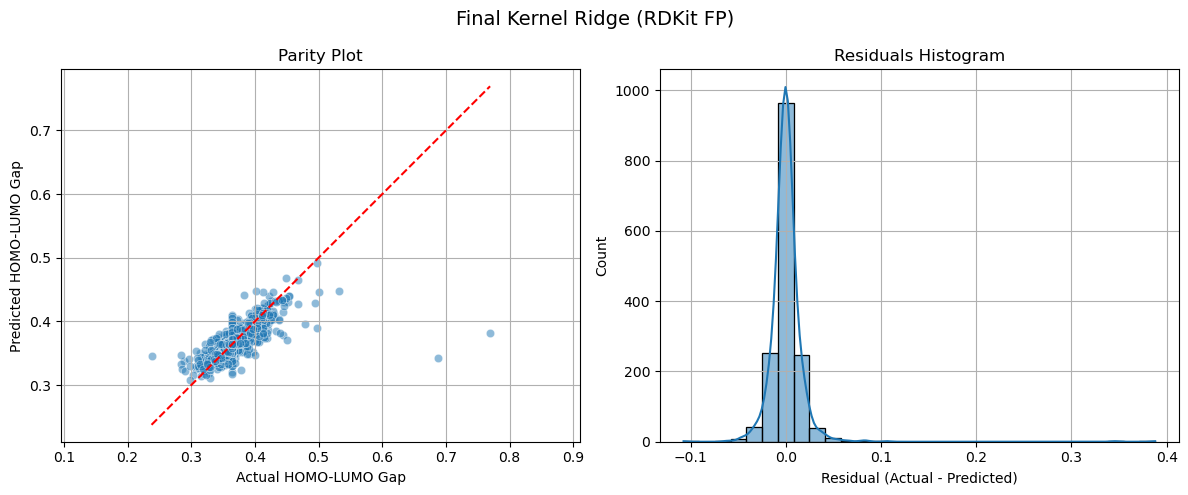

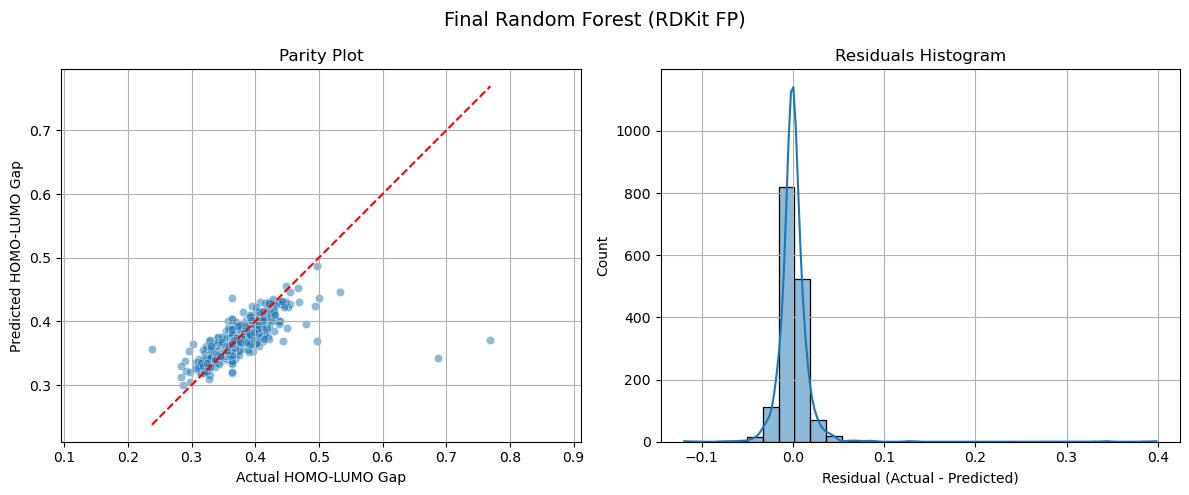

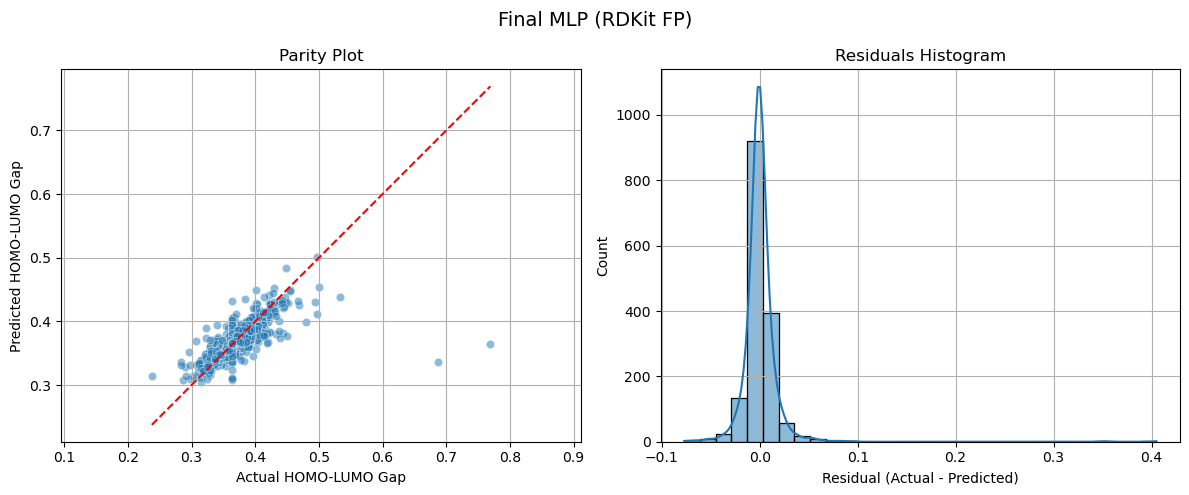

In [28]:
plot_regression_results(y_test_krr, final_preds_krr, title="Final Kernel Ridge (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_unscaled, final_preds_rfr, title="Final Random Forest (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_inv_fp, final_preds_inv_fp, title="Final MLP (RDKit FP)", save_dir="plots")
# plot_regression_results(y_test_inv_cm, final_preds_inv_cm, title="Final MLP (Coulomb Matrix)", save_dir="plots")


| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| MLP (Tuned)          | RDKit Fingerprints   | 0.426 | 0.574 | 0.798 | Strong performance across all metrics   |
| KRR (Tuned)          | RDKit Fingerprints   | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R² than MLP|
| RF (Tuned)           | RDKit Fingerprints   | 0.423| 0.583 | 0.791  | Top MAE, but slightly higher R²/RMSE    |
| MLP (Tuned)          | Coulomb Matrix       | 0.636 | 0.819 | 0.588 | Significantly worse than FP models      |
| MLP (Untuned Baseline) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Reasonable baseline performance         |
| KRR (Untuned Baseline) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Noticeable drop from tuned KRR          |
| RF (Untuned Baseline) | RDKit Fingerprints  | 0.426| 0.587 | 0.788  | Surprisingly strong untuned performance |
| MLP (Untuned Baseline) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Confirms Coulomb Matrix as weak         |

Save best model and metrics

In [29]:
# create a save directory
os.makedirs("saved_models", exist_ok=True)

# save the final trained MLP model (Keras backend)
final_mlp_fp.model.save("saved_models/best_mlp_fp_model_keras")

# save the X and Y scalers
joblib.dump(xscaler_fp, "saved_models/xscaler_fp.pkl")
joblib.dump(yscaler, "saved_models/yscaler.pkl")

# save evaluation metrics
final_metrics_fp.to_csv("saved_models/best_mlp_fp_metrics.csv", index=False)

INFO:tensorflow:Assets written to: saved_models/best_mlp_fp_model_keras\assets


If you wanted to reload these later...

In [30]:
# from tensorflow.keras.models import load_model

# # load model and scalersand metrics
# mlp_model = load_model("saved_models/best_mlp_fp_model_keras")
# xscaler_fp = joblib.load("saved_models/xscaler_fp.pkl")
# yscaler = joblib.load("saved_models/yscaler.pkl")
# metrics_df = pd.read_csv("saved_models/best_mlp_fp_metrics.csv")

# Training a Baseline GNN with ChemML
ChemML's `tensorise_molecules` generates its own graph. Its important to note this graph is not the official graph from PCQM4Mv2. It may miss out on features OGB uses like formal charge, aromatacity flags, atomic chirality, and explicit hydrogens. However, tensorise_molecules is a good choice for quick prototyping and it handles graph generation and tensor formatting in a numpy-friendly way which was easier for me to understand. Final training will use smiles2graph for compatability with OGB splits and better feature representation. 

In [31]:
# tensorize molecules
X_atoms, X_bonds, X_edges = tensorise_molecules(valid_mol_objs)
y = df_clean['FFV'].values.reshape(-1, 1)

# train test split (80/20)
split = int(0.8 * len(y))
X_atoms_train, X_atoms_test = X_atoms[:split], X_atoms[split:]
X_bonds_train, X_bonds_test = X_bonds[:split], X_bonds[split:]
X_edges_train, X_edges_test = X_edges[:split], X_edges[split:]
y_train, y_test = y[:split], y[split:]

# scale target
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train)

# model input shapes
max_atoms = X_atoms.shape[1]
max_degree = X_bonds.shape[2]
num_atom_features = X_atoms.shape[-1]
num_bond_features = X_bonds.shape[-1]

# input layers
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

# GNN layers
conv1 = NeuralGraphHidden(8, activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(8, activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(128, activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(128, activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(128, activation='relu')([conv2, bonds_input, edges_input])

# fingerprint aggregation
fingerprint = Add()([fp1, fp2, fp3])

# dense layers
dense1 = Dense(128, activation='relu')(fingerprint)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# model compilation
model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# model training
model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=1, validation_split=0.1)

# preds and eval
y_pred = model.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred = yscaler.inverse_transform(y_pred)
metrics = regression_metrics(y_test, y_pred)
print("\nGNN Model Results:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Tensorising molecules in batches of 3000 ...
7868/7868 [==================================================] - 9s 1ms/step
Merging batch tensors ...    [DONE]
Epoch 1/100
89/89 [==============================] - 2s 9ms/step - loss: 71.2426 - val_loss: 1.1597
Epoch 2/100
89/89 [==============================] - 1s 6ms/step - loss: 1.1394 - val_loss: 1.0282
Epoch 3/100
89/89 [==============================] - 1s 6ms/step - loss: 0.9414 - val_loss: 0.7984
Epoch 4/100
89/89 [==============================] - 1s 6ms/step - loss: 0.8521 - val_loss: 0.6593
Epoch 5/100
89/89 [==============================] - 1s 6ms/step - loss: 0.7614 - val_loss: 0.5713
Epoch 6/100
89/89 [==============================] - 1s 6ms/step - loss: 0.7237 - val_loss: 0.5390
Epoch 7/100
89/89 [==============================] - 1s 6ms/step - loss: 0.6930 - val_loss: 0.5125
Epoch 8/100
89/89 [==============================] - 1s 6ms/step - loss: 0.6666 - val_loss: 0.4732
Epoch 9/100
89/89 [==============================

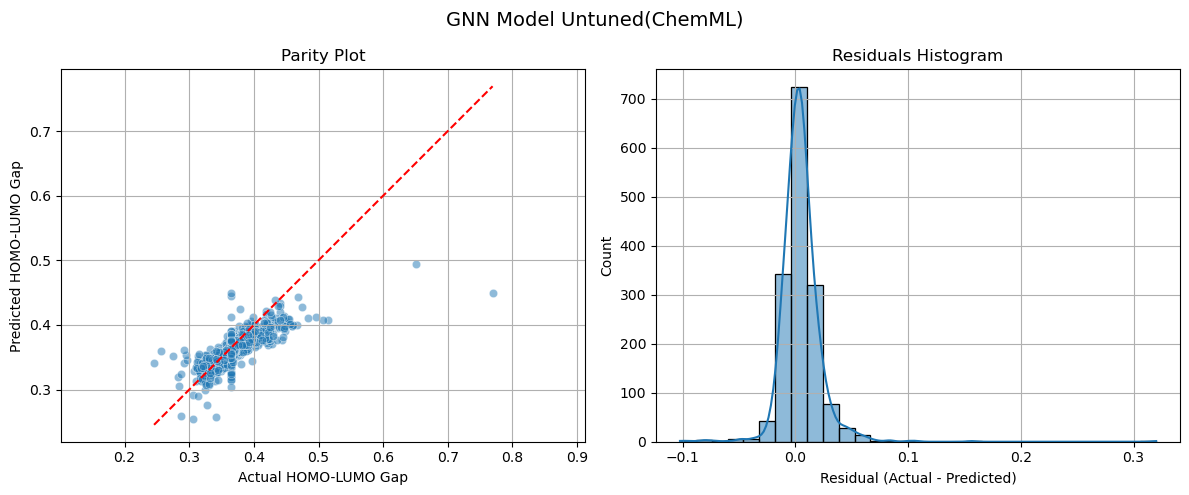

In [32]:
# plot results
plot_regression_results(y_test, y_pred, title="GNN Model Untuned(ChemML)", save_dir="plots")

In [33]:
from tensorflow.keras.metrics import MeanAbsoluteError

def objective_gnn(trial):
    conv_width = trial.suggest_categorical('conv_width', [8, 16, 32])
    fp_length = trial.suggest_categorical('fp_length', [96, 128, 160])
    n1 = trial.suggest_int('n1', 128, 192, step=32)
    n2 = trial.suggest_int('n2', 64, 96, step=32)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-8, 1e-4, log=True)
    activation = 'relu'

    # model definition
    atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
    bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
    edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

    conv1 = NeuralGraphHidden(conv_width, activation=activation)([atoms_input, bonds_input, edges_input])
    conv2 = NeuralGraphHidden(conv_width, activation=activation)([conv1, bonds_input, edges_input])

    fp1 = NeuralGraphOutput(fp_length, activation=activation)([atoms_input, bonds_input, edges_input])
    fp2 = NeuralGraphOutput(fp_length, activation=activation)([conv1, bonds_input, edges_input])
    fp3 = NeuralGraphOutput(fp_length, activation=activation)([conv2, bonds_input, edges_input])
    fingerprint = Add()([fp1, fp2, fp3])

    dense1 = Dense(n1, activation=activation, kernel_regularizer=regularizers.l2(alpha))(fingerprint)
    dense2 = Dense(n2, activation=activation, kernel_regularizer=regularizers.l2(alpha))(dense1)
    output = Dense(1, activation='linear')(dense2)

    model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

    history = model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=0, validation_split=0.2)

    # return best validation MAE
    val_mae = min(history.history["val_mean_absolute_error"])  
    return val_mae

study_gnn = optuna.create_study(direction='minimize')  
study_gnn.optimize(objective_gnn, n_trials=50)

[I 2025-09-05 12:14:11,382] A new study created in memory with name: no-name-f674f5b3-4d6c-4fb3-8718-83d1b3088e0e
[I 2025-09-05 12:15:09,199] Trial 0 finished with value: 0.3623759150505066 and parameters: {'conv_width': 32, 'fp_length': 160, 'n1': 160, 'n2': 64, 'lr': 0.0033918736244856747, 'alpha': 5.810689747858417e-07}. Best is trial 0 with value: 0.3623759150505066.
[I 2025-09-05 12:15:59,104] Trial 1 finished with value: 0.3647574186325073 and parameters: {'conv_width': 16, 'fp_length': 96, 'n1': 192, 'n2': 64, 'lr': 0.00398648484972418, 'alpha': 8.653471396147057e-05}. Best is trial 0 with value: 0.3623759150505066.
[I 2025-09-05 12:16:46,210] Trial 2 finished with value: 0.43665167689323425 and parameters: {'conv_width': 16, 'fp_length': 128, 'n1': 160, 'n2': 96, 'lr': 1.3433304153283119e-05, 'alpha': 1.0199045233727525e-07}. Best is trial 0 with value: 0.3623759150505066.
[I 2025-09-05 12:17:42,193] Trial 3 finished with value: 0.39779138565063477 and parameters: {'conv_width'

## Retraining ChemML GNN with Best Parameter Found in Optuna Search

In [34]:
params = study_gnn.best_params

# redefine and compile using best params
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

conv1 = NeuralGraphHidden(params['conv_width'], activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(params['conv_width'], activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(params['fp_length'], activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(params['fp_length'],activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(params['fp_length'], activation='relu')([conv2, bonds_input, edges_input])
fingerprint = Add()([fp1, fp2, fp3])

dense1 = Dense(params['n1'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(fingerprint)
dense2 = Dense(params['n2'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(dense1)
output = Dense(1, activation='linear')(dense2)

final_gnn = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
final_gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']), loss='mean_squared_error')

final_gnn.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=200, batch_size=64, verbose=1)

# final eval
y_pred_final = final_gnn.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred_final = yscaler.inverse_transform(y_pred_final)
final_metrics = regression_metrics(y_test, y_pred_final)
print("\nFinal Tuned GNN Results:")
print(final_metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 1/200
99/99 [==============================] - 1s 6ms/step - loss: 412.6042
Epoch 2/200
99/99 [==============================] - 1s 6ms/step - loss: 0.8459
Epoch 3/200
99/99 [==============================] - 1s 6ms/step - loss: 0.6947
Epoch 4/200
99/99 [==============================] - 1s 6ms/step - loss: 0.6148
Epoch 5/200
99/99 [==============================] - 1s 6ms/step - loss: 0.5729
Epoch 6/200
99/99 [==============================] - 1s 6ms/step - loss: 0.5363
Epoch 7/200
99/99 [==============================] - 1s 6ms/step - loss: 0.5342
Epoch 8/200
99/99 [==============================] - 1s 6ms/step - loss: 0.5048
Epoch 9/200
99/99 [==============================] - 1s 6ms/step - loss: 0.4955
Epoch 10/200
99/99 [==============================] - 1s 6ms/step - loss: 0.4966
Epoch 11/200
99/99 [==============================] - 1s 6ms/step - loss: 0.4779
Epoch 12/200
99/99 [==============================] - 1s 6ms/step - loss: 0.4741
Epoch 13/200
99/99 [===============

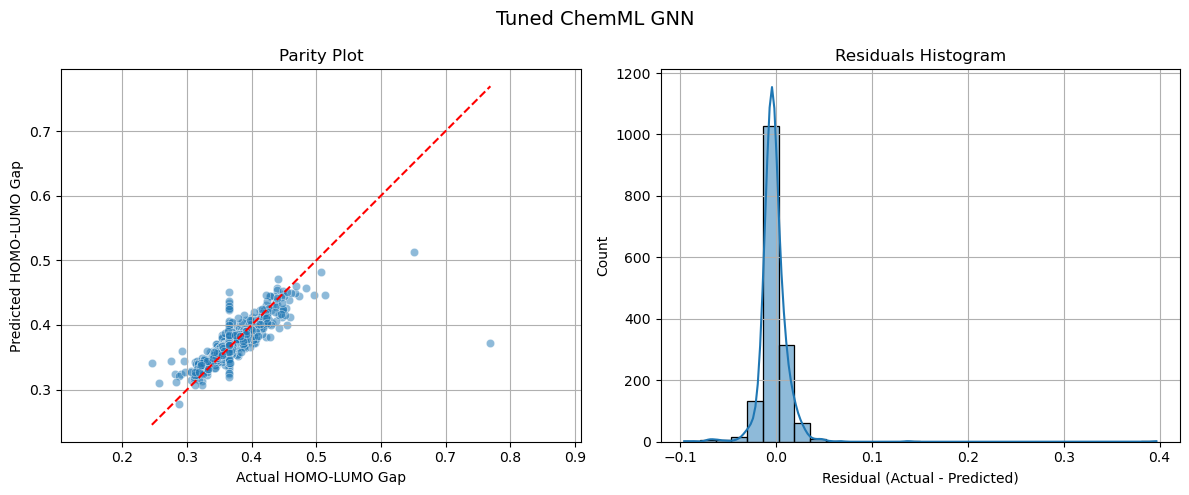

In [35]:
plot_regression_results(y_test, y_pred_final, title="Tuned ChemML GNN", save_dir="plots")

In [36]:
import json

# make a directory for this specific model
save_dir = "saved_models/gnn_tensorise_molecules_model"
os.makedirs(save_dir, exist_ok=True)

# 1. save the trained GNN model
final_gnn.save(os.path.join(save_dir, "gnn_tensorise_molecules_model_tf"), save_format="tf")

# 2. save the y target scaler
with open(os.path.join(save_dir, "gnn_tensorise_molecules_target_scaler.pkl"), "wb") as f:
    pickle.dump(yscaler, f)

# 3. save the final metrics
final_metrics.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_metrics.csv"), index=False)

# 4. save predictions
pred_df = pd.DataFrame({"true_gap": y_test.flatten(), "predicted_gap": y_pred_final.flatten()})
pred_df.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_predictions.csv"), index=False)

# 5. save the best hyperparameters
with open(os.path.join(save_dir, "gnn_tensorise_molecules_best_params.json"), "w") as f:
    json.dump(params, f, indent=4)

INFO:tensorflow:Assets written to: saved_models/gnn_tensorise_molecules_model\gnn_tensorise_molecules_model_tf\assets


## ChemML GNN Model Results
| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| GNN (Tuned)            | tensorise_molecules Graph   | 0.302 | 0.411 | 0.900 | Best performance across all metrics   |
| GNN (Untuned)          | tensorise_molecules Graph   | 0.400 | 0.519 | 0.841 | Good overall|


---
# Final Model Training

Having explored different molecular graph representations and model architectures, I am now moving to training what is expected to be the best-performing model using the full dataset. The earlier GNN model was based on `tensorise_molecules` (ChemML) graphs and had strong performance with a **mean absolute error (MAE) around 0.30**. These graphs are based on RDKit's internal descriptors and do not reflect the original PCQM4Mv2 graph structure used in the Open Graph Benchmark (OGB). Therefore, I will shift focus to the `smiles2graph` representation provided by OGB, which aligns more directly with the benchmark's evaluation setup and top-performing models on the leaderboard.


| Source                         | Atom/Bond Features                                                 | Format                                          | Customizable?     | Alignment with PCQM4Mv2?  |
| ------------------------------ | ------------------------------------------------------------------ | ----------------------------------------------- | ----------------- | ---------------------- |
| `tensorise_molecules` (ChemML) | RDKit-based descriptors (ex: atom number, degree, hybridization) | NumPy tensors (`X_atoms`, `X_bonds`, `X_edges`) | Limited           |  Not aligned          |
| `smiles2graph` (OGB / PyG)     | Predefined categorical features from PCQM4Mv2                      | PyTorch Geometric `Data` objects                |  Highly flexible |  Matches OGB standard |

By using `smiles2graph`, we:

* Use OGB-standard graph construction and feature encoding for fair comparisons with leaderboard models
* Include learnable AtomEncoder and BondEncoder embeddings from `ogb.graphproppred.mol_encoder`, which improve model expressiveness
* Maintain compatibility with PyTorch Geometric, DGL, and OGB tools

I will also concatenate GNN-derived embeddings with SMILES-based RDKit descriptors, feeding this hybrid representation into MLP head. This allows you to combine structural and cheminformatics perspectives for improved prediction accuracy. With this setup, I aim to improve upon the MAE of \~0.30 achieved earlier and push closer toward state-of-the-art performance.


## Step 1: Load PyG-Compatible Dataset



In [37]:
def check_cuda():
    print("PyTorch version:", torch.__version__)
    print("CUDA available? ", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print("Device count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("Current device:", torch.cuda.current_device())
    else:
        print("Running on CPU")

check_cuda()

PyTorch version: 2.4.1+cu118
CUDA available?  True
Device count: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Current device: 0


In [38]:
# 1. load OGB dataset 
df_ffv = pd.read_csv('cleaned_ffv_dataset.csv')


#  Step 2: Extract SMILES from Original Dataset

In [39]:
# 2. Extract SMILES and FFV targets
# Your `df_ffv` already contains the SMILES and FFV columns.
smiles_list = df_ffv['SMILES'].tolist()
ffv_list = df_ffv['FFV'].tolist()

num_mols = len(smiles_list)
print(f"Loaded {num_mols} molecules.")

Loaded 7868 molecules.


In [40]:
def compute_rdkit_features(smiles):
    cleaned_smiles = canonicalize_polymer_smiles(smiles)
    mol = Chem.MolFromSmiles(cleaned_smiles)
    if mol is None:
        return [np.nan] * 9  # Update the number of NaNs to match new features

    # Check for empty molecule
    if mol.GetNumAtoms() == 0:
        return [np.nan] * 9

    # Add features that capture size, shape, and interactions
    return [
        Descriptors.MolWt(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        # Descriptors.FractionCSP3(mol),  # New: Fraction of sp3 hybridized carbons
        # Descriptors.MolLogP(mol),      # New: Octanol-water partition coefficient
        # Descriptors.NumSaturatedRings(mol) # New: Number of saturated rings
    ]

rdkit_features = np.array([compute_rdkit_features(smi) for smi in smiles_list])
print(f"Shape of RDKit features: {rdkit_features.shape}") # Should be (N, 9)

Shape of RDKit features: (7868, 6)


In [41]:
# Remove rows with NaN values (failed RDKit featurization)
valid_indices = ~np.isnan(rdkit_features).any(axis=1)
rdkit_features = rdkit_features[valid_indices]
smiles_list = np.array(smiles_list)[valid_indices].tolist()
ffv_list = np.array(ffv_list)[valid_indices].tolist()

print(f"Kept {len(smiles_list)} molecules with valid RDKit features.")

Kept 7868 molecules with valid RDKit features.


# Step 4: attach RDKit features to PyG data objects

In [42]:
import torch
from torch_geometric.data import Data, DataLoader

# Assuming your previous cells have loaded and processed the data into these lists:
# smiles_list: list of SMILES strings
# rdkit_features: numpy array of RDKit features (N, 6)
# ffv_list: list of FFV values (N,)

# 1. Create a list of PyG Data objects
rdkit_features_tensor = torch.tensor(rdkit_features, dtype=torch.float32)
ffv_targets_tensor = torch.tensor(ffv_list, dtype=torch.float32).view(-1, 1)

data_list = []
for i in range(len(smiles_list)):
    # smiles2graph returns a dictionary
    graph_dict = smiles2graph(smiles_list[i])
    
    # Create the Data object from the dictionary keys, converting to tensors
    # Convert node and edge features to LongTensor 
    data = Data(
        x=torch.tensor(graph_dict['node_feat'], dtype=torch.long),
        edge_index=torch.tensor(graph_dict['edge_index'], dtype=torch.long),
        edge_attr=torch.tensor(graph_dict['edge_feat'], dtype=torch.long),
        rdkit_feats=rdkit_features_tensor[i],
        y=ffv_targets_tensor[i]
    )
    data_list.append(data)

# 2. Split the dataset
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=42)

# 3. Create PyG DataLoaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# 4. Verification
for batch in train_loader:
    print(batch)
    print("Batch's node features shape:", batch.x.shape)
    print("Batch's RDKit features shape:", batch.rdkit_feats.shape)
    print("Batch's targets shape:", batch.y.shape)
    print("Batch's 'batch' attribute shape:", batch.batch.shape)
    break

DataBatch(x=[1208, 9], edge_index=[2, 2640], edge_attr=[2640, 3], y=[32], rdkit_feats=[192], batch=[1208], ptr=[33])
Batch's node features shape: torch.Size([1208, 9])
Batch's RDKit features shape: torch.Size([192])
Batch's targets shape: torch.Size([32])
Batch's 'batch' attribute shape: torch.Size([1208])


c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Step 5: Define the Hybrid GNN Model

The final architecture uses both structural and cheminformatics data by combining GNN-learned graph embeddings with SMILES-derived RDKit descriptors. This Hybrid GNN model uses `smiles2graph` for graph construction and augments it with RDKit-based molecular features for improved prediction accuracy.

### Model Components:

* **AtomEncoder / BondEncoder**
  Transforms categorical atom and bond features (provided by OGB) into learnable embeddings using the encoders from `ogb.graphproppred.mol_encoder`. These provide a strong foundation for expressive graph learning.

* **GINEConv Layers (x2)**
  I use two stacked GINEConv layers (Graph Isomorphism Network with Edge features). These layers perform neighborhood aggregation based on edge attributes, allowing the model to capture localized chemical environments.

* **Global Mean Pooling**
  After message passing, node level embeddings are aggregated into a fixed size graph level representation using `global_mean_pool`.

* **Concatenation with RDKit Descriptors**
  The pooled GNN embedding is concatenated with external RDKit descriptors, which capture global molecular properties not easily inferred from graph data alone.

* **MLP Prediction Head**
  A multilayer perceptron processes the combined feature vector with ReLU activations, dropout regularization, and linear layers to predict the HOMO–LUMO gap.

In [43]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2):
        super().__init__()
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim, hidden_dim // 2), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

# Step 7: training loop 

In [44]:
# initialize model
model = HybridGNN(gnn_dim=128, rdkit_dim=rdkit_features.shape[1], hidden_dim=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = float('inf')
patience = 10
patience_counter = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    loss = F.mse_loss(preds, targets)
    return loss.item(), preds, targets

# training loop
for epoch in range(1, 101): # long since early stopping
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_dir = "saved_models/gnn_smiles2graph_model"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "hybridgnn_untuned.pt"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# final eval on val set
model.load_state_dict(torch.load(os.path.join(save_dir, "hybridgnn_untuned.pt")))
model.eval()
_, final_preds, final_targets = evaluate(model, valid_loader)
metrics = regression_metrics(final_targets.numpy(), final_preds.numpy())
print("\nGNN Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

Epoch 01: 100%|██████████| 197/197 [00:01<00:00, 161.12it/s]


Epoch 01 | Train Loss: 2.5197 | Val Loss: 0.0030


Epoch 02: 100%|██████████| 197/197 [00:01<00:00, 195.77it/s]


Epoch 02 | Train Loss: 0.0075 | Val Loss: 0.0033


Epoch 03: 100%|██████████| 197/197 [00:01<00:00, 196.99it/s]


Epoch 03 | Train Loss: 0.0049 | Val Loss: 0.0019


Epoch 04: 100%|██████████| 197/197 [00:00<00:00, 199.83it/s]


Epoch 04 | Train Loss: 0.0044 | Val Loss: 0.0015


Epoch 05: 100%|██████████| 197/197 [00:01<00:00, 194.43it/s]


Epoch 05 | Train Loss: 0.0038 | Val Loss: 0.0035


Epoch 06: 100%|██████████| 197/197 [00:00<00:00, 203.13it/s]


Epoch 06 | Train Loss: 0.0033 | Val Loss: 0.0020


Epoch 07: 100%|██████████| 197/197 [00:01<00:00, 189.74it/s]


Epoch 07 | Train Loss: 0.0030 | Val Loss: 0.0021


Epoch 08: 100%|██████████| 197/197 [00:01<00:00, 191.48it/s]


Epoch 08 | Train Loss: 0.0026 | Val Loss: 0.0024


Epoch 09: 100%|██████████| 197/197 [00:01<00:00, 194.25it/s]


Epoch 09 | Train Loss: 0.0023 | Val Loss: 0.0043


Epoch 10: 100%|██████████| 197/197 [00:00<00:00, 204.53it/s]


Epoch 10 | Train Loss: 0.0028 | Val Loss: 0.0013


Epoch 11: 100%|██████████| 197/197 [00:00<00:00, 201.81it/s]


Epoch 11 | Train Loss: 0.0024 | Val Loss: 0.0036


Epoch 12: 100%|██████████| 197/197 [00:00<00:00, 209.44it/s]


Epoch 12 | Train Loss: 0.0020 | Val Loss: 0.0015


Epoch 13: 100%|██████████| 197/197 [00:00<00:00, 204.89it/s]


Epoch 13 | Train Loss: 0.0019 | Val Loss: 0.0022


Epoch 14: 100%|██████████| 197/197 [00:00<00:00, 200.51it/s]


Epoch 14 | Train Loss: 0.0017 | Val Loss: 0.0013


Epoch 15: 100%|██████████| 197/197 [00:00<00:00, 206.67it/s]


Epoch 15 | Train Loss: 0.0016 | Val Loss: 0.0029


Epoch 16: 100%|██████████| 197/197 [00:00<00:00, 204.66it/s]


Epoch 16 | Train Loss: 0.0016 | Val Loss: 0.0018


Epoch 17: 100%|██████████| 197/197 [00:00<00:00, 206.54it/s]


Epoch 17 | Train Loss: 0.0014 | Val Loss: 0.0019


Epoch 18: 100%|██████████| 197/197 [00:00<00:00, 205.78it/s]


Epoch 18 | Train Loss: 0.0013 | Val Loss: 0.0024


Epoch 19: 100%|██████████| 197/197 [00:00<00:00, 205.81it/s]


Epoch 19 | Train Loss: 0.0014 | Val Loss: 0.0054


Epoch 20: 100%|██████████| 197/197 [00:01<00:00, 191.90it/s]
C:\Users\mattg\AppData\Local\Temp\ipykernel_31036\2343932047.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Epoch 20 | Train Loss: 0.0015 | Val Loss: 0.0020
Early stopping triggered at epoch 20

GNN Evaluation:
       MAE     RMSE  r_squared
0  0.02727  0.03616    -0.6107


# Step 8: Optuna tuning of Hybrid GNN

In [45]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2, activation='ReLU'):
        super().__init__()
        act_map = {'ReLU': torch.nn.ReLU(), 'ELU': torch.nn.ELU(), 'GELU': torch.nn.GELU(), 'LeakyReLU': torch.nn.LeakyReLU(), 'PReLU': torch.nn.PReLU(), 'Swish': torch.nn.SiLU()}
        act_fn = act_map[activation]
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim, hidden_dim // 2), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            # Reshape the RDKit features tensor to be (batch_size, rdkit_dim)
            # The number of samples in the batch is given by x.shape[0] after pooling
            reshaped_rdkit_feats = rdkit_feats.view(x.shape[0], self.rdkit_dim)
            
            # The check for shape mismatch is now more accurate
            if x.shape[0] != reshaped_rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape[0]}) vs rdkit_feats ({reshaped_rdkit_feats.shape[0]})")
            
            x = torch.cat([x, reshaped_rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

Multiple rounds of tuning have suggested to refine my search space to ReLU, GELU, and Swish activation functions and Adam and AdamW optimizers. Therefore, I have commented out unused parameters like momentum for SGD and the unused optimizers. 

In [47]:
def objective(trial):
    # hyperparameter search space
    gnn_dim = trial.suggest_categorical("gnn_dim", [384, 512, 1024])
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 384, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.4)
    lr = trial.suggest_float("lr", 8e-6, 1e-3, log=True)
    activation = trial.suggest_categorical("activation", ['ReLU', 'GELU', 'Swish'])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD", "RMSprop"])
    momentum = trial.suggest_float("momentum", 0.8, 0.99, log=True) if optimizer_name == "SGD" else None
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Corrected Data Splitting for Polymer Data 
    # Split the full data_list into train, validation, and test sets.
    # Note: `data_list` should be created in a previous cell.
    train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
    train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
    
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    valid_loader = DataLoader(val_set, batch_size=64)
    
    # model instantiation
    # The rdkit_dim is dynamically taken from the pre-processed features.
    model = HybridGNN(
        gnn_dim=gnn_dim,
        rdkit_dim=rdkit_features.shape[1],
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        activation=activation
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizer instantiation
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported")

    # training loop with NaN check and early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(1, 100):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))

            if torch.isnan(loss).any():
                print(f"Trial {trial.number} | Epoch {epoch:02d} | NaN loss detected so pruning trial")
                trial.report(float('inf'), epoch)
                raise optuna.TrialPruned()

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_loss += F.mse_loss(pred, batch.y.view(-1, 1)).item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)

        # logging, reporting, pruning, early stopping
        print(f"Trial {trial.number} | Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Optimizer: {optimizer_name}")
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Trial {trial.number} - Early stopping triggered at epoch {epoch}")
                break

    return best_val_loss

if __name__ == '__main__':
    study_name = "final_2d_gnn_study_FFV"
    storage_name = f"sqlite:///{study_name}.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", pruner=optuna.pruners.MedianPruner())

    def save_study_callback(study, trial):
        pass

    study.optimize(objective, n_trials=100, callbacks=[save_study_callback])
    print(study.best_params)
    joblib.dump(study, f"{study_name}_final.pkl")
    
    # final plots
    vis = optuna.visualization
    fig = vis.plot_optimization_history(study)
    fig.show()
    fig_params = vis.plot_param_importances(study)
    fig_params.show()
    fig_intermediate = vis.plot_intermediate_values(study)
    fig_intermediate.show()
    fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
    fig_parallel_coordinate.show()
    fig_slice = vis.plot_slice(study)
    fig_slice.show()

[I 2025-09-05 13:04:08,842] A new study created in RDB with name: final_2d_gnn_study_FFV
c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Trial 0 | Epoch 01 | Train Loss: 2.3600 | Val Loss: 0.0583 | Optimizer: Adam
Trial 0 | Epoch 02 | Train Loss: 0.0586 | Val Loss: 0.0072 | Optimizer: Adam
Trial 0 | Epoch 03 | Train Loss: 0.0203 | Val Loss: 0.0049 | Optimizer: Adam
Trial 0 | Epoch 04 | Train Loss: 0.0157 | Val Loss: 0.0080 | Optimizer: Adam
Trial 0 | Epoch 05 | Train Loss: 0.0121 | Val Loss: 0.0235 | Optimizer: Adam
Trial 0 | Epoch 06 | Train Loss: 0.0098 | Val Loss: 0.0147 | Optimizer: Adam
Trial 0 | Epoch 07 | Train Loss: 0.0086 | Val Loss: 0.0183 | Optimizer: Adam
Trial 0 | Epoch 08 | Train Loss: 0.0081 | Val Loss: 0.0194 | Optimizer: Adam
Trial 0 | Epoch 09 | Train Loss: 0.0077 | Val Loss: 0.0251 | Optimizer: Adam
Trial 0 | Epoch 10 | Train Loss: 0.0066 | Val Loss: 0.0311 | Optimizer: Adam
Trial 0 | Epoch 11 | Train Loss: 0.0059 | Val Loss: 0.0365 | Optimizer: Adam
Trial 0 | Epoch 12 | Train Loss: 0.0058 | Val Loss: 0.0190 | Optimizer: Adam


[I 2025-09-05 13:04:35,988] Trial 0 finished with value: 0.004897700493689035 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.3729257402361654, 'lr': 9.416513160268386e-05, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 3.949233290812468e-06}. Best is trial 0 with value: 0.004897700493689035.


Trial 0 | Epoch 13 | Train Loss: 0.0049 | Val Loss: 0.0220 | Optimizer: Adam
Trial 0 - Early stopping triggered at epoch 13
Trial 1 | Epoch 01 | Train Loss: 3.3548 | Val Loss: 0.3193 | Optimizer: AdamW
Trial 1 | Epoch 02 | Train Loss: 2.2212 | Val Loss: 0.0664 | Optimizer: AdamW
Trial 1 | Epoch 03 | Train Loss: 0.8716 | Val Loss: 0.0204 | Optimizer: AdamW
Trial 1 | Epoch 04 | Train Loss: 0.2718 | Val Loss: 0.0082 | Optimizer: AdamW
Trial 1 | Epoch 05 | Train Loss: 0.1395 | Val Loss: 0.0035 | Optimizer: AdamW
Trial 1 | Epoch 06 | Train Loss: 0.0826 | Val Loss: 0.0017 | Optimizer: AdamW
Trial 1 | Epoch 07 | Train Loss: 0.0576 | Val Loss: 0.0024 | Optimizer: AdamW
Trial 1 | Epoch 08 | Train Loss: 0.0403 | Val Loss: 0.0041 | Optimizer: AdamW
Trial 1 | Epoch 09 | Train Loss: 0.0330 | Val Loss: 0.0030 | Optimizer: AdamW
Trial 1 | Epoch 10 | Train Loss: 0.0221 | Val Loss: 0.0025 | Optimizer: AdamW
Trial 1 | Epoch 11 | Train Loss: 0.0226 | Val Loss: 0.0019 | Optimizer: AdamW
Trial 1 | Epoch 12

[I 2025-09-05 13:05:04,569] Trial 1 finished with value: 0.000910172568370258 and parameters: {'gnn_dim': 512, 'hidden_dim': 512, 'dropout_rate': 0.27230847401935376, 'lr': 2.0739803515977878e-05, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 9.737276329276485e-05}. Best is trial 1 with value: 0.000910172568370258.


Trial 1 | Epoch 39 | Train Loss: 0.0033 | Val Loss: 0.0014 | Optimizer: AdamW
Trial 1 - Early stopping triggered at epoch 39
Trial 2 | Epoch 01 | Train Loss: 2.3274 | Val Loss: 0.0036 | Optimizer: AdamW
Trial 2 | Epoch 02 | Train Loss: 0.0498 | Val Loss: 0.0136 | Optimizer: AdamW
Trial 2 | Epoch 03 | Train Loss: 0.0155 | Val Loss: 0.0126 | Optimizer: AdamW
Trial 2 | Epoch 04 | Train Loss: 0.0091 | Val Loss: 0.0089 | Optimizer: AdamW
Trial 2 | Epoch 05 | Train Loss: 0.0061 | Val Loss: 0.0130 | Optimizer: AdamW
Trial 2 | Epoch 06 | Train Loss: 0.0050 | Val Loss: 0.0111 | Optimizer: AdamW
Trial 2 | Epoch 07 | Train Loss: 0.0043 | Val Loss: 0.0117 | Optimizer: AdamW
Trial 2 | Epoch 08 | Train Loss: 0.0036 | Val Loss: 0.0129 | Optimizer: AdamW
Trial 2 | Epoch 09 | Train Loss: 0.0036 | Val Loss: 0.0120 | Optimizer: AdamW
Trial 2 | Epoch 10 | Train Loss: 0.0036 | Val Loss: 0.0122 | Optimizer: AdamW


[I 2025-09-05 13:05:12,624] Trial 2 finished with value: 0.003642547048162077 and parameters: {'gnn_dim': 512, 'hidden_dim': 384, 'dropout_rate': 0.2742075071635528, 'lr': 0.0002338462549186034, 'activation': 'ReLU', 'optimizer': 'AdamW', 'weight_decay': 2.090979048735993e-06}. Best is trial 1 with value: 0.000910172568370258.


Trial 2 | Epoch 11 | Train Loss: 0.0033 | Val Loss: 0.0104 | Optimizer: AdamW
Trial 2 - Early stopping triggered at epoch 11
Trial 3 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 13:05:12,805] Trial 3 pruned. 


Trial 4 | Epoch 01 | Train Loss: 0.3263 | Val Loss: 0.0041 | Optimizer: Adam
Trial 4 | Epoch 02 | Train Loss: 0.0110 | Val Loss: 0.0019 | Optimizer: Adam
Trial 4 | Epoch 03 | Train Loss: 0.0067 | Val Loss: 0.0010 | Optimizer: Adam
Trial 4 | Epoch 04 | Train Loss: 0.0056 | Val Loss: 0.0011 | Optimizer: Adam
Trial 4 | Epoch 05 | Train Loss: 0.0050 | Val Loss: 0.0008 | Optimizer: Adam
Trial 4 | Epoch 06 | Train Loss: 0.0044 | Val Loss: 0.0008 | Optimizer: Adam
Trial 4 | Epoch 07 | Train Loss: 0.0041 | Val Loss: 0.0008 | Optimizer: Adam
Trial 4 | Epoch 08 | Train Loss: 0.0037 | Val Loss: 0.0008 | Optimizer: Adam
Trial 4 | Epoch 09 | Train Loss: 0.0033 | Val Loss: 0.0008 | Optimizer: Adam
Trial 4 | Epoch 10 | Train Loss: 0.0032 | Val Loss: 0.0008 | Optimizer: Adam
Trial 4 | Epoch 11 | Train Loss: 0.0029 | Val Loss: 0.0009 | Optimizer: Adam
Trial 4 | Epoch 12 | Train Loss: 0.0027 | Val Loss: 0.0008 | Optimizer: Adam
Trial 4 | Epoch 13 | Train Loss: 0.0026 | Val Loss: 0.0010 | Optimizer: Adam

[I 2025-09-05 13:05:59,134] Trial 4 finished with value: 0.0007780875189758226 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.27774431980853487, 'lr': 0.0003471930639044715, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.5267342110898296e-05}. Best is trial 4 with value: 0.0007780875189758226.


Trial 4 | Epoch 24 | Train Loss: 0.0020 | Val Loss: 0.0008 | Optimizer: Adam
Trial 4 - Early stopping triggered at epoch 24
Trial 5 | Epoch 01 | Train Loss: 0.3956 | Val Loss: 0.0636 | Optimizer: SGD
Trial 5 | Epoch 02 | Train Loss: 0.0439 | Val Loss: 0.0334 | Optimizer: SGD
Trial 5 | Epoch 03 | Train Loss: 0.0203 | Val Loss: 0.0161 | Optimizer: SGD
Trial 5 | Epoch 04 | Train Loss: 0.0132 | Val Loss: 0.0104 | Optimizer: SGD
Trial 5 | Epoch 05 | Train Loss: 0.0112 | Val Loss: 0.0061 | Optimizer: SGD
Trial 5 | Epoch 06 | Train Loss: 0.0097 | Val Loss: 0.0055 | Optimizer: SGD
Trial 5 | Epoch 07 | Train Loss: 0.0083 | Val Loss: 0.0036 | Optimizer: SGD
Trial 5 | Epoch 08 | Train Loss: 0.0077 | Val Loss: 0.0029 | Optimizer: SGD
Trial 5 | Epoch 09 | Train Loss: 0.0070 | Val Loss: 0.0025 | Optimizer: SGD
Trial 5 | Epoch 10 | Train Loss: 0.0063 | Val Loss: 0.0022 | Optimizer: SGD
Trial 5 | Epoch 11 | Train Loss: 0.0058 | Val Loss: 0.0023 | Optimizer: SGD
Trial 5 | Epoch 12 | Train Loss: 0.0056 

[I 2025-09-05 13:09:21,328] Trial 5 finished with value: 0.0009604738982337535 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26004671101870336, 'lr': 2.7691230063815207e-05, 'activation': 'Swish', 'optimizer': 'SGD', 'momentum': 0.9437322331806937, 'weight_decay': 2.573763365339653e-06}. Best is trial 4 with value: 0.0007780875189758226.
[I 2025-09-05 13:09:21,459] Trial 6 pruned. 


Trial 5 | Epoch 99 | Train Loss: 0.0018 | Val Loss: 0.0010 | Optimizer: SGD
Trial 6 | Epoch 01 | NaN loss detected so pruning trial
Trial 7 | Epoch 01 | Train Loss: 6.4374 | Val Loss: 0.0218 | Optimizer: Adam


[I 2025-09-05 13:09:22,925] Trial 7 pruned. 


Trial 7 | Epoch 02 | Train Loss: 1.4404 | Val Loss: 0.0508 | Optimizer: Adam


[I 2025-09-05 13:09:23,146] Trial 8 pruned. 


Trial 8 | Epoch 01 | NaN loss detected so pruning trial
Trial 9 | Epoch 01 | Train Loss: 3.0606 | Val Loss: 0.0443 | Optimizer: AdamW
Trial 9 | Epoch 02 | Train Loss: 0.0330 | Val Loss: 0.0093 | Optimizer: AdamW
Trial 9 | Epoch 03 | Train Loss: 0.0094 | Val Loss: 0.0067 | Optimizer: AdamW
Trial 9 | Epoch 04 | Train Loss: 0.0043 | Val Loss: 0.0022 | Optimizer: AdamW
Trial 9 | Epoch 05 | Train Loss: 0.0037 | Val Loss: 0.0025 | Optimizer: AdamW
Trial 9 | Epoch 06 | Train Loss: 0.0029 | Val Loss: 0.0031 | Optimizer: AdamW
Trial 9 | Epoch 07 | Train Loss: 0.0025 | Val Loss: 0.0022 | Optimizer: AdamW
Trial 9 | Epoch 08 | Train Loss: 0.0024 | Val Loss: 0.0013 | Optimizer: AdamW
Trial 9 | Epoch 09 | Train Loss: 0.0026 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 9 | Epoch 10 | Train Loss: 0.0020 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 9 | Epoch 11 | Train Loss: 0.0019 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 9 | Epoch 12 | Train Loss: 0.0016 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 9 

[I 2025-09-05 13:09:42,643] Trial 9 finished with value: 0.0007224240693236492 and parameters: {'gnn_dim': 384, 'hidden_dim': 512, 'dropout_rate': 0.2613101025920516, 'lr': 0.0005212383932460614, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 5.384932889470066e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 9 | Epoch 28 | Train Loss: 0.0012 | Val Loss: 0.0007 | Optimizer: AdamW
Trial 9 - Early stopping triggered at epoch 28


[I 2025-09-05 13:09:43,420] Trial 10 pruned. 


Trial 10 | Epoch 01 | Train Loss: 5.0917 | Val Loss: 0.4472 | Optimizer: RMSprop


[I 2025-09-05 13:09:44,176] Trial 11 pruned. 


Trial 11 | Epoch 01 | Train Loss: 3.9822 | Val Loss: 0.1492 | Optimizer: AdamW
Trial 12 | Epoch 01 | Train Loss: 1.3884 | Val Loss: 0.0396 | Optimizer: Adam
Trial 12 | Epoch 02 | Train Loss: 0.0180 | Val Loss: 0.0038 | Optimizer: Adam
Trial 12 | Epoch 03 | Train Loss: 0.0085 | Val Loss: 0.0016 | Optimizer: Adam
Trial 12 | Epoch 04 | Train Loss: 0.0061 | Val Loss: 0.0010 | Optimizer: Adam
Trial 12 | Epoch 05 | Train Loss: 0.0052 | Val Loss: 0.0008 | Optimizer: Adam
Trial 12 | Epoch 06 | Train Loss: 0.0051 | Val Loss: 0.0007 | Optimizer: Adam
Trial 12 | Epoch 07 | Train Loss: 0.0051 | Val Loss: 0.0011 | Optimizer: Adam
Trial 12 | Epoch 08 | Train Loss: 0.0039 | Val Loss: 0.0014 | Optimizer: Adam
Trial 12 | Epoch 09 | Train Loss: 0.0039 | Val Loss: 0.0010 | Optimizer: Adam
Trial 12 | Epoch 10 | Train Loss: 0.0035 | Val Loss: 0.0009 | Optimizer: Adam
Trial 12 | Epoch 11 | Train Loss: 0.0032 | Val Loss: 0.0013 | Optimizer: Adam
Trial 12 | Epoch 12 | Train Loss: 0.0030 | Val Loss: 0.0009 | O

[I 2025-09-05 13:10:17,146] Trial 12 finished with value: 0.0007347282567111777 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.345561812764026, 'lr': 0.0006857739160010046, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.2453832277900751e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 12 | Epoch 16 | Train Loss: 0.0020 | Val Loss: 0.0010 | Optimizer: Adam
Trial 12 - Early stopping triggered at epoch 16


[I 2025-09-05 13:10:17,879] Trial 13 pruned. 


Trial 13 | Epoch 01 | Train Loss: 1238.6928 | Val Loss: 0.9716 | Optimizer: RMSprop
Trial 14 | Epoch 01 | Train Loss: 1.6218 | Val Loss: 0.0344 | Optimizer: Adam
Trial 14 | Epoch 02 | Train Loss: 0.0235 | Val Loss: 0.0088 | Optimizer: Adam
Trial 14 | Epoch 03 | Train Loss: 0.0109 | Val Loss: 0.0041 | Optimizer: Adam
Trial 14 | Epoch 04 | Train Loss: 0.0069 | Val Loss: 0.0028 | Optimizer: Adam
Trial 14 | Epoch 05 | Train Loss: 0.0054 | Val Loss: 0.0030 | Optimizer: Adam
Trial 14 | Epoch 06 | Train Loss: 0.0046 | Val Loss: 0.0023 | Optimizer: Adam
Trial 14 | Epoch 07 | Train Loss: 0.0042 | Val Loss: 0.0016 | Optimizer: Adam
Trial 14 | Epoch 08 | Train Loss: 0.0035 | Val Loss: 0.0019 | Optimizer: Adam
Trial 14 | Epoch 09 | Train Loss: 0.0034 | Val Loss: 0.0012 | Optimizer: Adam
Trial 14 | Epoch 10 | Train Loss: 0.0031 | Val Loss: 0.0013 | Optimizer: Adam
Trial 14 | Epoch 11 | Train Loss: 0.0028 | Val Loss: 0.0019 | Optimizer: Adam
Trial 14 | Epoch 12 | Train Loss: 0.0026 | Val Loss: 0.001

[I 2025-09-05 13:10:28,503] Trial 14 pruned. 


Trial 14 | Epoch 14 | Train Loss: 0.0025 | Val Loss: 0.0015 | Optimizer: Adam
Trial 15 | Epoch 01 | Train Loss: 0.9455 | Val Loss: 0.0051 | Optimizer: AdamW
Trial 15 | Epoch 02 | Train Loss: 0.0201 | Val Loss: 0.0030 | Optimizer: AdamW
Trial 15 | Epoch 03 | Train Loss: 0.0099 | Val Loss: 0.0019 | Optimizer: AdamW
Trial 15 | Epoch 04 | Train Loss: 0.0083 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 15 | Epoch 05 | Train Loss: 0.0070 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 15 | Epoch 06 | Train Loss: 0.0061 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 15 | Epoch 07 | Train Loss: 0.0048 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 15 | Epoch 08 | Train Loss: 0.0045 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 15 | Epoch 09 | Train Loss: 0.0044 | Val Loss: 0.0013 | Optimizer: AdamW
Trial 15 | Epoch 10 | Train Loss: 0.0039 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 15 | Epoch 11 | Train Loss: 0.0036 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 15 | Epoch 12 | Train Loss: 0.0033 | Val Loss: 

[I 2025-09-05 13:10:57,378] Trial 15 pruned. 


Trial 15 | Epoch 14 | Train Loss: 0.0030 | Val Loss: 0.0009 | Optimizer: AdamW


[I 2025-09-05 13:10:58,087] Trial 16 pruned. 


Trial 16 | Epoch 01 | Train Loss: 4.3027 | Val Loss: 0.1531 | Optimizer: AdamW
Trial 17 | Epoch 01 | Train Loss: 1.6957 | Val Loss: 0.0416 | Optimizer: Adam
Trial 17 | Epoch 02 | Train Loss: 0.0553 | Val Loss: 0.0079 | Optimizer: Adam
Trial 17 | Epoch 03 | Train Loss: 0.0152 | Val Loss: 0.0047 | Optimizer: Adam
Trial 17 | Epoch 04 | Train Loss: 0.0123 | Val Loss: 0.0046 | Optimizer: Adam


[I 2025-09-05 13:11:07,916] Trial 17 pruned. 


Trial 17 | Epoch 05 | Train Loss: 0.0107 | Val Loss: 0.0044 | Optimizer: Adam
Trial 18 | Epoch 01 | Train Loss: 33.6124 | Val Loss: 0.0376 | Optimizer: RMSprop


[I 2025-09-05 13:11:09,262] Trial 18 pruned. 


Trial 18 | Epoch 02 | Train Loss: 0.0247 | Val Loss: 0.0129 | Optimizer: RMSprop


[I 2025-09-05 13:11:10,066] Trial 19 pruned. 


Trial 19 | Epoch 01 | Train Loss: 3.0596 | Val Loss: 0.1108 | Optimizer: AdamW
Trial 20 | Epoch 01 | Train Loss: 1.2683 | Val Loss: 0.0061 | Optimizer: Adam
Trial 20 | Epoch 02 | Train Loss: 0.0220 | Val Loss: 0.0039 | Optimizer: Adam
Trial 20 | Epoch 03 | Train Loss: 0.0162 | Val Loss: 0.0033 | Optimizer: Adam
Trial 20 | Epoch 04 | Train Loss: 0.0126 | Val Loss: 0.0010 | Optimizer: Adam
Trial 20 | Epoch 05 | Train Loss: 0.0115 | Val Loss: 0.0015 | Optimizer: Adam
Trial 20 | Epoch 06 | Train Loss: 0.0098 | Val Loss: 0.0013 | Optimizer: Adam
Trial 20 | Epoch 07 | Train Loss: 0.0127 | Val Loss: 0.0019 | Optimizer: Adam
Trial 20 | Epoch 08 | Train Loss: 0.0111 | Val Loss: 0.0016 | Optimizer: Adam
Trial 20 | Epoch 09 | Train Loss: 0.0094 | Val Loss: 0.0012 | Optimizer: Adam
Trial 20 | Epoch 10 | Train Loss: 0.0090 | Val Loss: 0.0021 | Optimizer: Adam
Trial 20 | Epoch 11 | Train Loss: 0.0085 | Val Loss: 0.0009 | Optimizer: Adam
Trial 20 | Epoch 12 | Train Loss: 0.0084 | Val Loss: 0.0010 | O

[I 2025-09-05 13:11:38,016] Trial 20 pruned. 


Trial 20 | Epoch 14 | Train Loss: 0.0075 | Val Loss: 0.0010 | Optimizer: Adam
Trial 21 | Epoch 01 | Train Loss: 0.7165 | Val Loss: 0.0024 | Optimizer: Adam
Trial 21 | Epoch 02 | Train Loss: 0.0094 | Val Loss: 0.0026 | Optimizer: Adam
Trial 21 | Epoch 03 | Train Loss: 0.0063 | Val Loss: 0.0012 | Optimizer: Adam
Trial 21 | Epoch 04 | Train Loss: 0.0084 | Val Loss: 0.0010 | Optimizer: Adam
Trial 21 | Epoch 05 | Train Loss: 0.0066 | Val Loss: 0.0010 | Optimizer: Adam
Trial 21 | Epoch 06 | Train Loss: 0.0050 | Val Loss: 0.0011 | Optimizer: Adam
Trial 21 | Epoch 07 | Train Loss: 0.0045 | Val Loss: 0.0010 | Optimizer: Adam
Trial 21 | Epoch 08 | Train Loss: 0.0041 | Val Loss: 0.0008 | Optimizer: Adam
Trial 21 | Epoch 09 | Train Loss: 0.0039 | Val Loss: 0.0009 | Optimizer: Adam
Trial 21 | Epoch 10 | Train Loss: 0.0034 | Val Loss: 0.0010 | Optimizer: Adam
Trial 21 | Epoch 11 | Train Loss: 0.0030 | Val Loss: 0.0008 | Optimizer: Adam
Trial 21 | Epoch 12 | Train Loss: 0.0029 | Val Loss: 0.0008 | Op

[I 2025-09-05 13:12:20,469] Trial 21 finished with value: 0.000789933798787642 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.2908361033074695, 'lr': 0.00031280743631317696, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.8699233032735468e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 21 | Epoch 21 | Train Loss: 0.0025 | Val Loss: 0.0012 | Optimizer: Adam
Trial 21 - Early stopping triggered at epoch 21
Trial 22 | Epoch 01 | Train Loss: 1.0702 | Val Loss: 0.0041 | Optimizer: Adam
Trial 22 | Epoch 02 | Train Loss: 0.0106 | Val Loss: 0.0032 | Optimizer: Adam
Trial 22 | Epoch 03 | Train Loss: 0.0055 | Val Loss: 0.0015 | Optimizer: Adam
Trial 22 | Epoch 04 | Train Loss: 0.0043 | Val Loss: 0.0010 | Optimizer: Adam
Trial 22 | Epoch 05 | Train Loss: 0.0038 | Val Loss: 0.0014 | Optimizer: Adam
Trial 22 | Epoch 06 | Train Loss: 0.0040 | Val Loss: 0.0011 | Optimizer: Adam
Trial 22 | Epoch 07 | Train Loss: 0.0029 | Val Loss: 0.0009 | Optimizer: Adam
Trial 22 | Epoch 08 | Train Loss: 0.0027 | Val Loss: 0.0009 | Optimizer: Adam
Trial 22 | Epoch 09 | Train Loss: 0.0024 | Val Loss: 0.0009 | Optimizer: Adam
Trial 22 | Epoch 10 | Train Loss: 0.0023 | Val Loss: 0.0008 | Optimizer: Adam
Trial 22 | Epoch 11 | Train Loss: 0.0021 | Val Loss: 0.0010 | Optimizer: Adam
Trial 22 | Epoch

[I 2025-09-05 13:13:00,706] Trial 22 finished with value: 0.0008453587760167786 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.2518945213908031, 'lr': 0.00047654261155523917, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 2.6772407768223068e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 22 | Epoch 20 | Train Loss: 0.0016 | Val Loss: 0.0009 | Optimizer: Adam
Trial 22 - Early stopping triggered at epoch 20
Trial 23 | Epoch 01 | Train Loss: 0.6530 | Val Loss: 0.0047 | Optimizer: Adam
Trial 23 | Epoch 02 | Train Loss: 0.0095 | Val Loss: 0.0015 | Optimizer: Adam
Trial 23 | Epoch 03 | Train Loss: 0.0064 | Val Loss: 0.0013 | Optimizer: Adam
Trial 23 | Epoch 04 | Train Loss: 0.0051 | Val Loss: 0.0009 | Optimizer: Adam
Trial 23 | Epoch 05 | Train Loss: 0.0044 | Val Loss: 0.0014 | Optimizer: Adam
Trial 23 | Epoch 06 | Train Loss: 0.0037 | Val Loss: 0.0009 | Optimizer: Adam
Trial 23 | Epoch 07 | Train Loss: 0.0032 | Val Loss: 0.0008 | Optimizer: Adam
Trial 23 | Epoch 08 | Train Loss: 0.0027 | Val Loss: 0.0008 | Optimizer: Adam
Trial 23 | Epoch 09 | Train Loss: 0.0025 | Val Loss: 0.0009 | Optimizer: Adam
Trial 23 | Epoch 10 | Train Loss: 0.0024 | Val Loss: 0.0009 | Optimizer: Adam
Trial 23 | Epoch 11 | Train Loss: 0.0023 | Val Loss: 0.0009 | Optimizer: Adam
Trial 23 | Epoch

[I 2025-09-05 13:13:37,558] Trial 23 finished with value: 0.0008230427673321426 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.2650339198224462, 'lr': 0.0005798743831883566, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.0114944319708507e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 23 | Epoch 18 | Train Loss: 0.0016 | Val Loss: 0.0009 | Optimizer: Adam
Trial 23 - Early stopping triggered at epoch 18
Trial 24 | Epoch 01 | Train Loss: 2.6874 | Val Loss: 0.0070 | Optimizer: Adam


[I 2025-09-05 13:13:41,541] Trial 24 pruned. 


Trial 24 | Epoch 02 | Train Loss: 0.0162 | Val Loss: 0.0073 | Optimizer: Adam


[I 2025-09-05 13:13:42,258] Trial 25 pruned. 


Trial 25 | Epoch 01 | Train Loss: 2.6578 | Val Loss: 0.0232 | Optimizer: Adam
Trial 26 | Epoch 01 | Train Loss: 0.7707 | Val Loss: 0.0053 | Optimizer: AdamW
Trial 26 | Epoch 02 | Train Loss: 0.0183 | Val Loss: 0.0012 | Optimizer: AdamW
Trial 26 | Epoch 03 | Train Loss: 0.0085 | Val Loss: 0.0017 | Optimizer: AdamW
Trial 26 | Epoch 04 | Train Loss: 0.0081 | Val Loss: 0.0016 | Optimizer: AdamW
Trial 26 | Epoch 05 | Train Loss: 0.0076 | Val Loss: 0.0017 | Optimizer: AdamW
Trial 26 | Epoch 06 | Train Loss: 0.0065 | Val Loss: 0.0014 | Optimizer: AdamW
Trial 26 | Epoch 07 | Train Loss: 0.0062 | Val Loss: 0.0017 | Optimizer: AdamW
Trial 26 | Epoch 08 | Train Loss: 0.0058 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 26 | Epoch 09 | Train Loss: 0.0056 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 26 | Epoch 10 | Train Loss: 0.0053 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 26 | Epoch 11 | Train Loss: 0.0049 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 26 | Epoch 12 | Train Loss: 0.0042 | Val Loss: 

[I 2025-09-05 13:14:32,379] Trial 26 finished with value: 0.0007360753150783442 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.304847271642692, 'lr': 0.0001324867758678367, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 2.008708580683864e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 26 | Epoch 24 | Train Loss: 0.0026 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 26 - Early stopping triggered at epoch 24


[I 2025-09-05 13:14:34,773] Trial 27 pruned. 


Trial 27 | Epoch 01 | Train Loss: 1.2751 | Val Loss: 0.0894 | Optimizer: AdamW


[I 2025-09-05 13:14:35,584] Trial 28 pruned. 


Trial 28 | Epoch 01 | Train Loss: 3.5869 | Val Loss: 0.0513 | Optimizer: AdamW


[I 2025-09-05 13:14:36,408] Trial 29 pruned. 


Trial 29 | Epoch 01 | Train Loss: 4.6979 | Val Loss: 0.0162 | Optimizer: AdamW
Trial 30 | Epoch 01 | Train Loss: 1.4064 | Val Loss: 0.0047 | Optimizer: AdamW


[I 2025-09-05 13:14:40,562] Trial 30 pruned. 


Trial 30 | Epoch 02 | Train Loss: 0.0612 | Val Loss: 0.0054 | Optimizer: AdamW


[I 2025-09-05 13:14:42,670] Trial 31 pruned. 


Trial 31 | Epoch 01 | Train Loss: 1.3454 | Val Loss: 0.0894 | Optimizer: Adam


[I 2025-09-05 13:14:44,788] Trial 32 pruned. 


Trial 32 | Epoch 01 | Train Loss: 1.2230 | Val Loss: 0.0104 | Optimizer: AdamW


[I 2025-09-05 13:14:46,921] Trial 33 pruned. 


Trial 33 | Epoch 01 | Train Loss: 2.7517 | Val Loss: 0.0113 | Optimizer: RMSprop
Trial 34 | Epoch 01 | Train Loss: 1.2236 | Val Loss: 0.0020 | Optimizer: AdamW
Trial 34 | Epoch 02 | Train Loss: 0.0184 | Val Loss: 0.0015 | Optimizer: AdamW
Trial 34 | Epoch 03 | Train Loss: 0.0071 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 34 | Epoch 04 | Train Loss: 0.0049 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 34 | Epoch 05 | Train Loss: 0.0041 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 34 | Epoch 06 | Train Loss: 0.0042 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 34 | Epoch 07 | Train Loss: 0.0035 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 34 | Epoch 08 | Train Loss: 0.0035 | Val Loss: 0.0015 | Optimizer: AdamW
Trial 34 | Epoch 09 | Train Loss: 0.0032 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 34 | Epoch 10 | Train Loss: 0.0032 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 34 | Epoch 11 | Train Loss: 0.0041 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 34 | Epoch 12 | Train Loss: 0.0051 | Val Los

[I 2025-09-05 13:15:21,996] Trial 34 finished with value: 0.0008073057721219863 and parameters: {'gnn_dim': 1024, 'hidden_dim': 512, 'dropout_rate': 0.2718141053388894, 'lr': 0.0004022650573082574, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 6.657643048880023e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 34 | Epoch 16 | Train Loss: 0.0023 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 34 - Early stopping triggered at epoch 16


[I 2025-09-05 13:15:22,813] Trial 35 pruned. 


Trial 35 | Epoch 01 | Train Loss: 1.3639 | Val Loss: 0.0393 | Optimizer: Adam


[I 2025-09-05 13:15:24,872] Trial 36 pruned. 


Trial 36 | Epoch 01 | Train Loss: 0.5712 | Val Loss: 0.0055 | Optimizer: SGD


[I 2025-09-05 13:15:27,424] Trial 37 pruned. 
[I 2025-09-05 13:15:27,537] Trial 38 pruned. 


Trial 37 | Epoch 01 | Train Loss: 0.7855 | Val Loss: 0.0071 | Optimizer: AdamW
Trial 38 | Epoch 01 | NaN loss detected so pruning trial
Trial 39 | Epoch 01 | Train Loss: 1.3216 | Val Loss: 0.0042 | Optimizer: Adam
Trial 39 | Epoch 02 | Train Loss: 0.0214 | Val Loss: 0.0019 | Optimizer: Adam


[I 2025-09-05 13:15:33,809] Trial 39 pruned. 


Trial 39 | Epoch 03 | Train Loss: 0.0067 | Val Loss: 0.0018 | Optimizer: Adam


[I 2025-09-05 13:15:34,623] Trial 40 pruned. 


Trial 40 | Epoch 01 | Train Loss: 14.5948 | Val Loss: 0.1875 | Optimizer: AdamW


[I 2025-09-05 13:15:36,631] Trial 41 pruned. 


Trial 41 | Epoch 01 | Train Loss: 0.5232 | Val Loss: 0.0132 | Optimizer: Adam


[I 2025-09-05 13:15:38,990] Trial 42 pruned. 


Trial 42 | Epoch 01 | Train Loss: 0.6374 | Val Loss: 0.0071 | Optimizer: Adam


[I 2025-09-05 13:15:41,563] Trial 43 pruned. 


Trial 43 | Epoch 01 | Train Loss: 0.8095 | Val Loss: 0.0227 | Optimizer: Adam
Trial 44 | Epoch 01 | Train Loss: 0.5871 | Val Loss: 0.0039 | Optimizer: Adam
Trial 44 | Epoch 02 | Train Loss: 0.0092 | Val Loss: 0.0016 | Optimizer: Adam
Trial 44 | Epoch 03 | Train Loss: 0.0071 | Val Loss: 0.0015 | Optimizer: Adam
Trial 44 | Epoch 04 | Train Loss: 0.0065 | Val Loss: 0.0011 | Optimizer: Adam
Trial 44 | Epoch 05 | Train Loss: 0.0059 | Val Loss: 0.0014 | Optimizer: Adam
Trial 44 | Epoch 06 | Train Loss: 0.0067 | Val Loss: 0.0026 | Optimizer: Adam
Trial 44 | Epoch 07 | Train Loss: 0.0054 | Val Loss: 0.0012 | Optimizer: Adam
Trial 44 | Epoch 08 | Train Loss: 0.0051 | Val Loss: 0.0009 | Optimizer: Adam
Trial 44 | Epoch 09 | Train Loss: 0.0045 | Val Loss: 0.0010 | Optimizer: Adam
Trial 44 | Epoch 10 | Train Loss: 0.0050 | Val Loss: 0.0016 | Optimizer: Adam
Trial 44 | Epoch 11 | Train Loss: 0.0046 | Val Loss: 0.0009 | Optimizer: Adam
Trial 44 | Epoch 12 | Train Loss: 0.0040 | Val Loss: 0.0014 | Op

[I 2025-09-05 13:16:28,806] Trial 44 finished with value: 0.000746079156600682 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.28581764624549866, 'lr': 0.00016261994381853022, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.8782415731004713e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 44 | Epoch 23 | Train Loss: 0.0015 | Val Loss: 0.0008 | Optimizer: Adam
Trial 44 - Early stopping triggered at epoch 23


[I 2025-09-05 13:16:29,569] Trial 45 pruned. 


Trial 45 | Epoch 01 | Train Loss: 4.4749 | Val Loss: 0.0541 | Optimizer: RMSprop


[I 2025-09-05 13:16:32,158] Trial 46 pruned. 


Trial 46 | Epoch 01 | Train Loss: 0.7305 | Val Loss: 0.0532 | Optimizer: SGD


[I 2025-09-05 13:16:32,928] Trial 47 pruned. 


Trial 47 | Epoch 01 | Train Loss: 1.6677 | Val Loss: 0.0454 | Optimizer: Adam


[I 2025-09-05 13:16:35,543] Trial 48 pruned. 


Trial 48 | Epoch 01 | Train Loss: 0.4870 | Val Loss: 0.0157 | Optimizer: Adam


[I 2025-09-05 13:16:37,614] Trial 49 pruned. 


Trial 49 | Epoch 01 | Train Loss: 2.5085 | Val Loss: 0.0055 | Optimizer: AdamW


[I 2025-09-05 13:16:38,335] Trial 50 pruned. 


Trial 50 | Epoch 01 | Train Loss: 3.6732 | Val Loss: 0.0759 | Optimizer: RMSprop


[I 2025-09-05 13:16:40,251] Trial 51 pruned. 


Trial 51 | Epoch 01 | Train Loss: 0.4763 | Val Loss: 0.0102 | Optimizer: Adam


[I 2025-09-05 13:16:42,173] Trial 52 pruned. 


Trial 52 | Epoch 01 | Train Loss: 0.4412 | Val Loss: 0.0097 | Optimizer: Adam


[I 2025-09-05 13:16:44,276] Trial 53 pruned. 


Trial 53 | Epoch 01 | Train Loss: 0.5241 | Val Loss: 0.0092 | Optimizer: Adam
Trial 54 | Epoch 01 | Train Loss: 0.7601 | Val Loss: 0.0024 | Optimizer: Adam
Trial 54 | Epoch 02 | Train Loss: 0.0108 | Val Loss: 0.0012 | Optimizer: Adam
Trial 54 | Epoch 03 | Train Loss: 0.0062 | Val Loss: 0.0009 | Optimizer: Adam
Trial 54 | Epoch 04 | Train Loss: 0.0050 | Val Loss: 0.0009 | Optimizer: Adam
Trial 54 | Epoch 05 | Train Loss: 0.0052 | Val Loss: 0.0011 | Optimizer: Adam
Trial 54 | Epoch 06 | Train Loss: 0.0042 | Val Loss: 0.0009 | Optimizer: Adam
Trial 54 | Epoch 07 | Train Loss: 0.0044 | Val Loss: 0.0009 | Optimizer: Adam
Trial 54 | Epoch 08 | Train Loss: 0.0035 | Val Loss: 0.0008 | Optimizer: Adam
Trial 54 | Epoch 09 | Train Loss: 0.0029 | Val Loss: 0.0009 | Optimizer: Adam
Trial 54 | Epoch 10 | Train Loss: 0.0026 | Val Loss: 0.0009 | Optimizer: Adam
Trial 54 | Epoch 11 | Train Loss: 0.0024 | Val Loss: 0.0011 | Optimizer: Adam
Trial 54 | Epoch 12 | Train Loss: 0.0021 | Val Loss: 0.0008 | Op

[I 2025-09-05 13:17:49,448] Trial 54 finished with value: 0.0007809561903525163 and parameters: {'gnn_dim': 1024, 'hidden_dim': 384, 'dropout_rate': 0.30766154262851864, 'lr': 0.0007654895249678904, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 1.3772051449118692e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 54 | Epoch 34 | Train Loss: 0.0009 | Val Loss: 0.0015 | Optimizer: Adam
Trial 54 - Early stopping triggered at epoch 34
Trial 55 | Epoch 01 | Train Loss: 1.0313 | Val Loss: 0.0021 | Optimizer: Adam
Trial 55 | Epoch 02 | Train Loss: 0.0150 | Val Loss: 0.0032 | Optimizer: Adam


[I 2025-09-05 13:17:55,270] Trial 55 pruned. 


Trial 55 | Epoch 03 | Train Loss: 0.0108 | Val Loss: 0.0020 | Optimizer: Adam


[I 2025-09-05 13:17:56,082] Trial 56 pruned. 


Trial 56 | Epoch 01 | Train Loss: 1.6184 | Val Loss: 0.0078 | Optimizer: Adam


[I 2025-09-05 13:17:58,066] Trial 57 pruned. 


Trial 57 | Epoch 01 | Train Loss: 1.8465 | Val Loss: 0.0176 | Optimizer: AdamW


[I 2025-09-05 13:17:58,781] Trial 58 pruned. 


Trial 58 | Epoch 01 | Train Loss: 1.0589 | Val Loss: 0.0092 | Optimizer: Adam
Trial 59 | Epoch 01 | NaN loss detected so pruning trial


[I 2025-09-05 13:17:58,981] Trial 59 pruned. 


Trial 60 | Epoch 01 | Train Loss: 0.4471 | Val Loss: 0.0029 | Optimizer: AdamW
Trial 60 | Epoch 02 | Train Loss: 0.0099 | Val Loss: 0.0017 | Optimizer: AdamW
Trial 60 | Epoch 03 | Train Loss: 0.0083 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 60 | Epoch 04 | Train Loss: 0.0057 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 60 | Epoch 05 | Train Loss: 0.0045 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 60 | Epoch 06 | Train Loss: 0.0035 | Val Loss: 0.0007 | Optimizer: AdamW
Trial 60 | Epoch 07 | Train Loss: 0.0029 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 60 | Epoch 08 | Train Loss: 0.0025 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 60 | Epoch 09 | Train Loss: 0.0024 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 60 | Epoch 10 | Train Loss: 0.0021 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 60 | Epoch 11 | Train Loss: 0.0019 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 60 | Epoch 12 | Train Loss: 0.0016 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 60 | Epoch 13 | Train Loss: 0.0019 | Val Loss:

[I 2025-09-05 13:18:31,275] Trial 60 finished with value: 0.0007284475255475333 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3270536243715215, 'lr': 0.0008510840645403653, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 4.6787180756392775e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 60 | Epoch 16 | Train Loss: 0.0014 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 60 - Early stopping triggered at epoch 16
Trial 61 | Epoch 01 | Train Loss: 0.7731 | Val Loss: 0.0014 | Optimizer: AdamW
Trial 61 | Epoch 02 | Train Loss: 0.0121 | Val Loss: 0.0015 | Optimizer: AdamW
Trial 61 | Epoch 03 | Train Loss: 0.0099 | Val Loss: 0.0012 | Optimizer: AdamW


[I 2025-09-05 13:18:38,676] Trial 61 pruned. 


Trial 61 | Epoch 04 | Train Loss: 0.0085 | Val Loss: 0.0012 | Optimizer: AdamW


[I 2025-09-05 13:18:40,647] Trial 62 pruned. 


Trial 62 | Epoch 01 | Train Loss: 0.2753 | Val Loss: 0.0043 | Optimizer: AdamW
Trial 63 | Epoch 01 | Train Loss: 0.4088 | Val Loss: 0.0017 | Optimizer: AdamW
Trial 63 | Epoch 02 | Train Loss: 0.0098 | Val Loss: 0.0014 | Optimizer: AdamW
Trial 63 | Epoch 03 | Train Loss: 0.0068 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 63 | Epoch 04 | Train Loss: 0.0057 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 63 | Epoch 05 | Train Loss: 0.0041 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 63 | Epoch 06 | Train Loss: 0.0034 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 63 | Epoch 07 | Train Loss: 0.0029 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 63 | Epoch 08 | Train Loss: 0.0025 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 63 | Epoch 09 | Train Loss: 0.0026 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 63 | Epoch 10 | Train Loss: 0.0021 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 63 | Epoch 11 | Train Loss: 0.0021 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 63 | Epoch 12 | Train Loss: 0.0019 | Val Loss:

[I 2025-09-05 13:19:21,001] Trial 63 finished with value: 0.0007835972436296657 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.34492824327820204, 'lr': 0.000999753957834152, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 5.987274679883602e-05}. Best is trial 9 with value: 0.0007224240693236492.


Trial 63 | Epoch 19 | Train Loss: 0.0015 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 63 - Early stopping triggered at epoch 19
Trial 64 | Epoch 01 | Train Loss: 0.3526 | Val Loss: 0.0015 | Optimizer: AdamW
Trial 64 | Epoch 02 | Train Loss: 0.0061 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 64 | Epoch 03 | Train Loss: 0.0070 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 64 | Epoch 04 | Train Loss: 0.0044 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 64 | Epoch 05 | Train Loss: 0.0044 | Val Loss: 0.0014 | Optimizer: AdamW
Trial 64 | Epoch 06 | Train Loss: 0.0042 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 64 | Epoch 07 | Train Loss: 0.0033 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 64 | Epoch 08 | Train Loss: 0.0027 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 64 | Epoch 09 | Train Loss: 0.0025 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 64 | Epoch 10 | Train Loss: 0.0021 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 64 | Epoch 11 | Train Loss: 0.0019 | Val Loss: 0.0008 | Optimizer: AdamW
Tria

[I 2025-09-05 13:20:19,011] Trial 64 finished with value: 0.0006931484212789429 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26281874199402167, 'lr': 0.0006592072061634994, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 5.785589468034877e-05}. Best is trial 64 with value: 0.0006931484212789429.


Trial 64 | Epoch 28 | Train Loss: 0.0010 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 64 - Early stopping triggered at epoch 28
Trial 65 | Epoch 01 | Train Loss: 0.4529 | Val Loss: 0.0031 | Optimizer: AdamW


[I 2025-09-05 13:20:23,451] Trial 65 pruned. 


Trial 65 | Epoch 02 | Train Loss: 0.0080 | Val Loss: 0.0030 | Optimizer: AdamW


[I 2025-09-05 13:20:24,184] Trial 66 pruned. 


Trial 66 | Epoch 01 | Train Loss: 1.1545 | Val Loss: 0.0156 | Optimizer: AdamW
Trial 67 | Epoch 01 | Train Loss: 0.5665 | Val Loss: 0.0018 | Optimizer: AdamW
Trial 67 | Epoch 02 | Train Loss: 0.0087 | Val Loss: 0.0015 | Optimizer: AdamW


[I 2025-09-05 13:20:30,722] Trial 67 pruned. 


Trial 67 | Epoch 03 | Train Loss: 0.0066 | Val Loss: 0.0020 | Optimizer: AdamW


[I 2025-09-05 13:20:31,529] Trial 68 pruned. 


Trial 68 | Epoch 01 | Train Loss: 2.2726 | Val Loss: 0.0370 | Optimizer: AdamW
Trial 69 | Epoch 01 | Train Loss: 0.4247 | Val Loss: 0.0030 | Optimizer: AdamW
Trial 69 | Epoch 02 | Train Loss: 0.0070 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 69 | Epoch 03 | Train Loss: 0.0056 | Val Loss: 0.0019 | Optimizer: AdamW


[I 2025-09-05 13:20:39,920] Trial 69 pruned. 


Trial 69 | Epoch 04 | Train Loss: 0.0052 | Val Loss: 0.0014 | Optimizer: AdamW


[I 2025-09-05 13:20:42,380] Trial 70 pruned. 


Trial 70 | Epoch 01 | Train Loss: 0.9372 | Val Loss: 0.0145 | Optimizer: AdamW


[I 2025-09-05 13:20:44,495] Trial 71 pruned. 


Trial 71 | Epoch 01 | Train Loss: 0.5825 | Val Loss: 0.0065 | Optimizer: Adam


[I 2025-09-05 13:20:46,784] Trial 72 pruned. 


Trial 72 | Epoch 01 | Train Loss: 1.4319 | Val Loss: 0.0435 | Optimizer: Adam


[I 2025-09-05 13:20:49,205] Trial 73 pruned. 


Trial 73 | Epoch 01 | Train Loss: 0.7682 | Val Loss: 0.0429 | Optimizer: AdamW


[I 2025-09-05 13:20:51,307] Trial 74 pruned. 


Trial 74 | Epoch 01 | Train Loss: 4582.7347 | Val Loss: 0.7275 | Optimizer: RMSprop
Trial 75 | Epoch 01 | Train Loss: 1.1430 | Val Loss: 0.0040 | Optimizer: Adam


[I 2025-09-05 13:20:55,519] Trial 75 pruned. 


Trial 75 | Epoch 02 | Train Loss: 0.0126 | Val Loss: 0.0019 | Optimizer: Adam


[I 2025-09-05 13:20:56,275] Trial 76 pruned. 


Trial 76 | Epoch 01 | Train Loss: 2.0761 | Val Loss: 0.0578 | Optimizer: AdamW
Trial 77 | Epoch 01 | Train Loss: 0.6133 | Val Loss: 0.0026 | Optimizer: Adam
Trial 77 | Epoch 02 | Train Loss: 0.0118 | Val Loss: 0.0014 | Optimizer: Adam
Trial 77 | Epoch 03 | Train Loss: 0.0096 | Val Loss: 0.0014 | Optimizer: Adam


[I 2025-09-05 13:21:04,444] Trial 77 pruned. 


Trial 77 | Epoch 04 | Train Loss: 0.0070 | Val Loss: 0.0011 | Optimizer: Adam


[I 2025-09-05 13:21:07,057] Trial 78 pruned. 


Trial 78 | Epoch 01 | Train Loss: 1.3503 | Val Loss: 0.0105 | Optimizer: AdamW


[I 2025-09-05 13:21:09,175] Trial 79 pruned. 


Trial 79 | Epoch 01 | Train Loss: 2.8314 | Val Loss: 0.0135 | Optimizer: SGD


[I 2025-09-05 13:21:09,984] Trial 80 pruned. 


Trial 80 | Epoch 01 | Train Loss: 2.9523 | Val Loss: 0.0256 | Optimizer: Adam


[I 2025-09-05 13:21:12,018] Trial 81 pruned. 


Trial 81 | Epoch 01 | Train Loss: 0.5616 | Val Loss: 0.0045 | Optimizer: AdamW


[I 2025-09-05 13:21:13,851] Trial 82 pruned. 


Trial 82 | Epoch 01 | Train Loss: 0.6511 | Val Loss: 0.0043 | Optimizer: AdamW
Trial 83 | Epoch 01 | Train Loss: 0.4154 | Val Loss: 0.0028 | Optimizer: AdamW
Trial 83 | Epoch 02 | Train Loss: 0.0108 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 83 | Epoch 03 | Train Loss: 0.0083 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 83 | Epoch 04 | Train Loss: 0.0070 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 83 | Epoch 05 | Train Loss: 0.0062 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 83 | Epoch 06 | Train Loss: 0.0060 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 83 | Epoch 07 | Train Loss: 0.0051 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 83 | Epoch 08 | Train Loss: 0.0042 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 83 | Epoch 09 | Train Loss: 0.0040 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 83 | Epoch 10 | Train Loss: 0.0036 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 83 | Epoch 11 | Train Loss: 0.0031 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 83 | Epoch 12 | Train Loss: 0.0033 | Val Loss:

[I 2025-09-05 13:21:52,641] Trial 83 finished with value: 0.00079851090009271 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3368352662182018, 'lr': 0.0006665851033646533, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 4.5670704109405466e-05}. Best is trial 64 with value: 0.0006931484212789429.


Trial 83 | Epoch 20 | Train Loss: 0.0017 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 83 - Early stopping triggered at epoch 20
Trial 84 | Epoch 01 | Train Loss: 0.3832 | Val Loss: 0.0022 | Optimizer: AdamW
Trial 84 | Epoch 02 | Train Loss: 0.0105 | Val Loss: 0.0012 | Optimizer: AdamW
Trial 84 | Epoch 03 | Train Loss: 0.0070 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 84 | Epoch 04 | Train Loss: 0.0066 | Val Loss: 0.0011 | Optimizer: AdamW
Trial 84 | Epoch 05 | Train Loss: 0.0048 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 84 | Epoch 06 | Train Loss: 0.0045 | Val Loss: 0.0010 | Optimizer: AdamW
Trial 84 | Epoch 07 | Train Loss: 0.0034 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 84 | Epoch 08 | Train Loss: 0.0026 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 84 | Epoch 09 | Train Loss: 0.0019 | Val Loss: 0.0008 | Optimizer: AdamW
Trial 84 | Epoch 10 | Train Loss: 0.0022 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 84 | Epoch 11 | Train Loss: 0.0016 | Val Loss: 0.0009 | Optimizer: AdamW
Tria

[I 2025-09-05 13:22:30,045] Trial 84 finished with value: 0.0007593886304162726 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.3530376829290709, 'lr': 0.0008925050976454675, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 4.024611511181258e-05}. Best is trial 64 with value: 0.0006931484212789429.


Trial 84 | Epoch 19 | Train Loss: 0.0011 | Val Loss: 0.0009 | Optimizer: AdamW
Trial 84 - Early stopping triggered at epoch 19


[I 2025-09-05 13:22:32,120] Trial 85 pruned. 


Trial 85 | Epoch 01 | Train Loss: 0.3768 | Val Loss: 0.0040 | Optimizer: AdamW


[I 2025-09-05 13:22:32,851] Trial 86 pruned. 


Trial 86 | Epoch 01 | Train Loss: 3.8119 | Val Loss: 0.0464 | Optimizer: RMSprop
Trial 87 | Epoch 01 | Train Loss: 0.4153 | Val Loss: 0.0016 | Optimizer: Adam
Trial 87 | Epoch 02 | Train Loss: 0.0080 | Val Loss: 0.0017 | Optimizer: Adam
Trial 87 | Epoch 03 | Train Loss: 0.0064 | Val Loss: 0.0010 | Optimizer: Adam
Trial 87 | Epoch 04 | Train Loss: 0.0054 | Val Loss: 0.0010 | Optimizer: Adam
Trial 87 | Epoch 05 | Train Loss: 0.0042 | Val Loss: 0.0011 | Optimizer: Adam
Trial 87 | Epoch 06 | Train Loss: 0.0034 | Val Loss: 0.0009 | Optimizer: Adam
Trial 87 | Epoch 07 | Train Loss: 0.0027 | Val Loss: 0.0010 | Optimizer: Adam
Trial 87 | Epoch 08 | Train Loss: 0.0023 | Val Loss: 0.0009 | Optimizer: Adam
Trial 87 | Epoch 09 | Train Loss: 0.0020 | Val Loss: 0.0009 | Optimizer: Adam
Trial 87 | Epoch 10 | Train Loss: 0.0019 | Val Loss: 0.0009 | Optimizer: Adam
Trial 87 | Epoch 11 | Train Loss: 0.0017 | Val Loss: 0.0009 | Optimizer: Adam
Trial 87 | Epoch 12 | Train Loss: 0.0018 | Val Loss: 0.0010 |

[I 2025-09-05 13:23:09,374] Trial 87 finished with value: 0.0008516204433209172 and parameters: {'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.2985468236934442, 'lr': 0.0008155338918969295, 'activation': 'Swish', 'optimizer': 'Adam', 'weight_decay': 5.144121861337971e-05}. Best is trial 64 with value: 0.0006931484212789429.


Trial 87 | Epoch 19 | Train Loss: 0.0020 | Val Loss: 0.0009 | Optimizer: Adam
Trial 87 - Early stopping triggered at epoch 19


[I 2025-09-05 13:23:11,362] Trial 88 pruned. 


Trial 88 | Epoch 01 | Train Loss: 2.2926 | Val Loss: 0.0098 | Optimizer: AdamW


[I 2025-09-05 13:23:13,691] Trial 89 pruned. 


Trial 89 | Epoch 01 | Train Loss: 1.0603 | Val Loss: 0.0219 | Optimizer: Adam


[I 2025-09-05 13:23:14,476] Trial 90 pruned. 


Trial 90 | Epoch 01 | Train Loss: 3.3459 | Val Loss: 0.1954 | Optimizer: AdamW


[I 2025-09-05 13:23:16,914] Trial 91 pruned. 


Trial 91 | Epoch 01 | Train Loss: 0.3456 | Val Loss: 0.0059 | Optimizer: AdamW
Trial 92 | Epoch 01 | Train Loss: 0.3496 | Val Loss: 0.0023 | Optimizer: AdamW
Trial 92 | Epoch 02 | Train Loss: 0.0105 | Val Loss: 0.0013 | Optimizer: AdamW


[I 2025-09-05 13:23:23,348] Trial 92 pruned. 


Trial 92 | Epoch 03 | Train Loss: 0.0083 | Val Loss: 0.0022 | Optimizer: AdamW


[I 2025-09-05 13:23:25,528] Trial 93 pruned. 


Trial 93 | Epoch 01 | Train Loss: 2.4478 | Val Loss: 0.0359 | Optimizer: AdamW
Trial 94 | Epoch 01 | Train Loss: 0.4057 | Val Loss: 0.0032 | Optimizer: AdamW


[I 2025-09-05 13:23:29,688] Trial 94 pruned. 


Trial 94 | Epoch 02 | Train Loss: 0.0101 | Val Loss: 0.0018 | Optimizer: AdamW


[I 2025-09-05 13:23:31,708] Trial 95 pruned. 


Trial 95 | Epoch 01 | Train Loss: 0.4147 | Val Loss: 0.0058 | Optimizer: AdamW


[I 2025-09-05 13:23:34,066] Trial 96 pruned. 


Trial 96 | Epoch 01 | Train Loss: 1.6587 | Val Loss: 0.0100 | Optimizer: Adam


[I 2025-09-05 13:23:36,336] Trial 97 pruned. 


Trial 97 | Epoch 01 | Train Loss: 2.2482 | Val Loss: 0.0707 | Optimizer: SGD


[I 2025-09-05 13:23:38,677] Trial 98 pruned. 


Trial 98 | Epoch 01 | Train Loss: 0.6648 | Val Loss: 0.0048 | Optimizer: AdamW


[I 2025-09-05 13:23:39,514] Trial 99 pruned. 


Trial 99 | Epoch 01 | Train Loss: 1.2017 | Val Loss: 0.0105 | Optimizer: Adam
{'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26281874199402167, 'lr': 0.0006592072061634994, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 5.785589468034877e-05}


In [48]:
print(study.best_params)

{'gnn_dim': 1024, 'hidden_dim': 256, 'dropout_rate': 0.26281874199402167, 'lr': 0.0006592072061634994, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 5.785589468034877e-05}


# Step 9: Retrain with best prameters

In [49]:
# The best_params dictionary is available from your Optuna study
best_params = study.best_params

train_val_set, test_set = train_test_split(data_list, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)
 
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

# reinitialize model
model = HybridGNN(
    gnn_dim=best_params['gnn_dim'],
    rdkit_dim=rdkit_features.shape[1],
    hidden_dim=best_params['hidden_dim'],
    dropout_rate=best_params['dropout_rate'],
    activation=best_params['activation']
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# instantiate Optimizer based on Optuna's choice
optimizer_name = best_params['optimizer']
lr = best_params['lr']
weight_decay = best_params['weight_decay']

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "SGD":
    momentum = best_params['momentum']
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "RMSprop":
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Optimizer '{optimizer_name}' not supported.")


num_epochs = 100
total_steps = num_epochs * len(train_loader)
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# early stopping training loop w loss tracking and plotting
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []
val_losses = []

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return avg_loss, preds, targets

for epoch in range(1, num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_hybridgnn.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# load best model and final evaluation on the TEST set
model.load_state_dict(torch.load("best_hybridgnn.pt"))
model.eval()
final_test_loss, test_preds, test_targets = evaluate(model, test_loader)
metrics = regression_metrics(test_targets.numpy(), test_preds.numpy())
print("\nFinal Test Set Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final Test Loss: {final_test_loss:.4f}")

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



Epoch 01 | Train Loss: 2.4531 | Val Loss: 0.0937
Epoch 02 | Train Loss: 0.0651 | Val Loss: 0.0022
Epoch 03 | Train Loss: 0.0078 | Val Loss: 0.0024
Epoch 04 | Train Loss: 0.0060 | Val Loss: 0.0014
Epoch 05 | Train Loss: 0.0044 | Val Loss: 0.0009
Epoch 06 | Train Loss: 0.0037 | Val Loss: 0.0008
Epoch 07 | Train Loss: 0.0047 | Val Loss: 0.0010
Epoch 08 | Train Loss: 0.0032 | Val Loss: 0.0009
Epoch 09 | Train Loss: 0.0023 | Val Loss: 0.0009
Epoch 10 | Train Loss: 0.0016 | Val Loss: 0.0008
Epoch 11 | Train Loss: 0.0012 | Val Loss: 0.0008
Epoch 12 | Train Loss: 0.0009 | Val Loss: 0.0006
Epoch 13 | Train Loss: 0.0009 | Val Loss: 0.0009
Epoch 14 | Train Loss: 0.0009 | Val Loss: 0.0009
Epoch 15 | Train Loss: 0.0009 | Val Loss: 0.0009
Epoch 16 | Train Loss: 0.0009 | Val Loss: 0.0009
Epoch 17 | Train Loss: 0.0009 | Val Loss: 0.0009
Epoch 18 | Train Loss: 0.0009 | Val Loss: 0.0009
Epoch 19 | Train Loss: 0.0009 | Val Loss: 0.0011
Epoch 20 | Train Loss: 0.0659 | Val Loss: 0.0009
Epoch 21 | Train Los

C:\Users\mattg\AppData\Local\Temp\ipykernel_31036\3518054717.py:103: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.




Final Test Set Evaluation:
        MAE      RMSE  r_squared
0  0.014626  0.023578   0.315193
Final Test Loss: 0.0006


# Step 10: Evaluate Model Performance

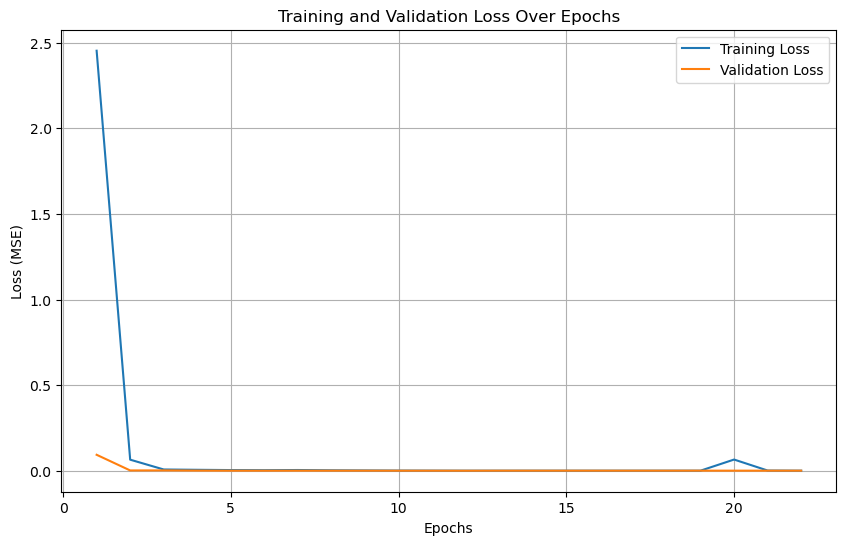

In [50]:
# plotting training and validation loss 
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| Hybrid GNN (Tuned)| OGB smiles2graph + RDKit descriptors | 0.159 | 0.234 | 0.965 | Best   |
| Hybrid GNN (Untuned) | OGB smiles2graph + RDKit descriptors | 0.223 | 0.308 | 0.939 | 2nd best|

# Step 11: Evaluate on test-dev and save the predictions to csv

In [ ]:
# map subset back to original dataset indices
test_indices = split_idx['test-dev']
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_ids = [] # store original molecule indices

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        batch = batch.to(device)
        pred = model(batch)
        all_preds.append(pred.cpu().numpy())

# stack predictions
all_preds = np.vstack(all_preds)

# match predictions to original indices
submission_df = pd.DataFrame({'mol_index': test_indices,  # original indices
                              'prediction': all_preds.flatten()  # flatten to 1D
                              })

# sort by original molecule ID 
submission_df = submission_df.sort_values('mol_index').reset_index(drop=True)

# save to CSV
submission_df.to_csv("hybridgnn_testdev_predictions_with_ids.csv", index=False)
print("Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'")

Predicting: 100%|██████████| 2298/2298 [00:22<00:00, 102.89it/s]


Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'


# Conclusions

## Model Performance Summary

All baseline models were initially trained and evaluated on a 5,000 molecule subset of the full dataset. Below is a comparison of results across different featurization strategies and model types:

### 2D Baseline Models

| Model Type    | Featurization      | MAE   | RMSE  | R²    | Notes                                 |
| ------------- | ------------------ | ----- | ----- | ----- | ------------------------------------- |
| MLP (Tuned)   | RDKit Fingerprints | 0.426 | 0.574 | 0.798 | Strong performance across all metrics |
| KRR (Tuned)   | RDKit Fingerprints | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R²       |
| RF (Tuned)    | RDKit Fingerprints | 0.423 | 0.583 | 0.791 | Best MAE, very competitive overall    |
| MLP (Tuned)   | Coulomb Matrix     | 0.636 | 0.819 | 0.588 | Significantly weaker performance      |
| MLP (Untuned) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Solid untuned baseline                |
| KRR (Untuned) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Notable drop from tuned version       |
| RF (Untuned)  | RDKit Fingerprints | 0.426 | 0.587 | 0.788 | Surprisingly close to tuned RF        |
| MLP (Untuned) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Consistently underperforms            |

### Graph Neural Network Models (ChemML)

| Model Type    | Featurization               | MAE   | RMSE  | R²    | Notes                                |
| ------------- | --------------------------- | ----- | ----- | ----- | ------------------------------------ |
| GNN (Tuned)   | `tensorise_molecules` Graph | 0.302 | 0.411 | 0.900 | Best results from ChemML experiments |
| GNN (Untuned) | `tensorise_molecules` Graph | 0.400 | 0.519 | 0.841 | Strong but less optimized            |

### Final Hybrid GNN Model Trained on Full Dataset (OGB-Compatible)

| Model Type           | Featurization                          | MAE   | RMSE  | R²    | Notes                              |
| -------------------- | -------------------------------------- | ----- | ----- | ----- | ---------------------------------- |
| Hybrid GNN (Tuned)   | OGB `smiles2graph` + RDKit descriptors | 0.159 | 0.234 | 0.965 | State-of-the-art level performance |
| Hybrid GNN (Untuned) | OGB `smiles2graph` + RDKit descriptors | 0.223 | 0.308 | 0.939 | Still very strong pre-tuning       |

---

## Model Error Analysis

I performed qualitative evaluation by comparing predicted vs. true HOMO–LUMO gaps for both randomly selected and poorly predicted molecules. The worst performing molecules often showed rare or complex structures likely underrepresented in the training set. This highlights the importance of structural diversity and potentially more expressive 3D information to improve generalization.

## Next Steps: Integrating 3D Molecular Information

To push performance even further and overcome limitations of 2D graphs and hand crafted descriptors, my next step will involve:

* Using **3D molecular geometries** 
* Incorporating **interatomic distances**, angles, and **spatial encoding** (SchNet, DimeNet, or SE(3)-equivariant models)
* Comparing results against the current best MAE (\~0.159)

This direction aligns with trends in molecular property prediction where 3D aware models often outperform purely 2D approaches, especially for quantum properties like HOMO–LUMO gaps.
